In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-account-fraud-dataset-neurips-2022/Base.csv
/kaggle/input/bank-account-fraud-dataset-neurips-2022/Variant IV.csv
/kaggle/input/bank-account-fraud-dataset-neurips-2022/Variant V.csv
/kaggle/input/bank-account-fraud-dataset-neurips-2022/Variant I.csv
/kaggle/input/bank-account-fraud-dataset-neurips-2022/Variant III.csv
/kaggle/input/bank-account-fraud-dataset-neurips-2022/Variant II.csv


In [2]:
import pandas as pd

# Import the datasets
base = pd.read_csv('/kaggle/input/bank-account-fraud-dataset-neurips-2022/Base.csv')
variant_1 = pd.read_csv('/kaggle/input/bank-account-fraud-dataset-neurips-2022/Variant I.csv')
variant_2 = pd.read_csv('/kaggle/input/bank-account-fraud-dataset-neurips-2022/Variant II.csv')
variant_3 = pd.read_csv('/kaggle/input/bank-account-fraud-dataset-neurips-2022/Variant III.csv')
variant_4 = pd.read_csv('/kaggle/input/bank-account-fraud-dataset-neurips-2022/Variant IV.csv')
variant_5 = pd.read_csv('/kaggle/input/bank-account-fraud-dataset-neurips-2022/Variant V.csv')

In [3]:
# Install and import LightGBM and XGBoost
!pip install lightgbm xgboost

!pip install fairlearn aif360

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.3/232.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 10.8 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.utils import resample
from imblearn.over_sampling import SMOTENC

# Existing imports
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Fairness libraries
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing

datasets = {
    "Base": base,
    "Variant I": variant_1,
    "Variant II": variant_2,
    "Variant III": variant_3,
    "Variant IV": variant_4,
    "Variant V": variant_5,
}

train_test_data = {}

# Define the sensitive attribute
sensitive_attribute = 'employment_status'  # Replace with your sensitive attribute

# Process each dataset
for name, data_raw in datasets.items():
    print(f"Processing Dataset: {name}")
    
    # Verify if target column exists
    target_variable = 'fraud_bool'
    if target_variable not in data_raw.columns:
        raise ValueError(f"'{target_variable}' column not found in {name} dataset. Please check the column name.")

    # Balance the dataset by downsampling the majority class
    df_fraud = data_raw[data_raw[target_variable] == 1]
    df_non_fraud = data_raw[data_raw[target_variable] == 0]
    
    df_non_fraud_downsampled = resample(df_non_fraud,
                                        replace=False,
                                        n_samples=len(df_fraud),
                                        random_state=42)
    
    # Combine the minority and downsampled majority class
    df_balanced = pd.concat([df_fraud, df_non_fraud_downsampled])
    
    # Shuffle the dataset and reset the index
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # Verify that 'month' column exists
    if 'month' not in df_balanced.columns:
        raise ValueError(f"'month' column not found in {name} dataset. Please check the column name.")

    # Split the data into train and test based on the "month" feature
    train_data = df_balanced[df_balanced['month'].between(0, 5)]
    test_data = df_balanced[df_balanced['month'].between(6, 7)]
    
    # Drop the "month" feature from train and test sets
    train_data = train_data.drop(columns=['month'])
    test_data = test_data.drop(columns=['month'])
    
    # Reset index
    train_data.reset_index(drop=True, inplace=True)
    test_data.reset_index(drop=True, inplace=True)
    
    # Separate features and target variable
    X_train = train_data.drop(columns=[target_variable])
    y_train = train_data[target_variable]
    X_test = test_data.drop(columns=[target_variable])
    y_test = test_data[target_variable]
    
    # Check if the sensitive attribute exists
    if sensitive_attribute not in X_train.columns:
        raise ValueError(f"'{sensitive_attribute}' column not found in {name} dataset. Please check the column name.")

    # Identify categorical features (including the sensitive attribute)
    categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
    # Ensure the sensitive attribute is included in categorical_features
    if sensitive_attribute not in categorical_features:
        categorical_features.append(sensitive_attribute)
    
    # Get indices of categorical features
    categorical_features_indices = [X_train.columns.get_loc(col) for col in categorical_features]

    # Apply OrdinalEncoder to categorical features (including sensitive attribute)
    ordinal_encoder = OrdinalEncoder(dtype=np.int32)
    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()

    if categorical_features:
        # Fit the encoder on combined data to ensure all categories are captured
        combined_categories = pd.concat([X_train_encoded[categorical_features], X_test_encoded[categorical_features]])
        ordinal_encoder.fit(combined_categories)

        X_train_encoded[categorical_features] = ordinal_encoder.transform(X_train_encoded[categorical_features])
        X_test_encoded[categorical_features] = ordinal_encoder.transform(X_test_encoded[categorical_features])

    # Apply SMOTENC to X_train_encoded and y_train
    smote_nc = SMOTENC(categorical_features=categorical_features_indices, random_state=42)
    X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train_encoded, y_train)

    # Ensure that categorical features remain integer after SMOTENC
    for col in categorical_features:
        X_train_resampled[col] = X_train_resampled[col].round(0).astype(int)

    # Extract the sensitive attribute after resampling (but do not drop it yet)
    S_train_resampled = X_train_resampled[sensitive_attribute]
    # We'll drop the sensitive attribute later

    # For X_test_encoded, extract the encoded sensitive attribute
    S_test_encoded = X_test_encoded[sensitive_attribute]

    # Proceed with further preprocessing (e.g., scaling numerical features)
    # Exclude categorical features (including the sensitive attribute) from scaling
    numerical_features = X_train_resampled.columns.difference(categorical_features)

    preprocessor = StandardScaler()

    X_train_scaled = preprocessor.fit_transform(X_train_resampled[numerical_features])
    X_test_scaled = preprocessor.transform(X_test_encoded[numerical_features])

    # Convert scaled numerical features back to DataFrames
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=numerical_features)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=numerical_features)

    # Combine scaled numerical features with categorical features (including sensitive attribute)
    X_train_processed = pd.concat([X_train_scaled.reset_index(drop=True),
                                   X_train_resampled[categorical_features].reset_index(drop=True)], axis=1)
    X_test_processed = pd.concat([X_test_scaled.reset_index(drop=True),
                                  X_test_encoded[categorical_features].reset_index(drop=True)], axis=1)

    # Now drop the sensitive attribute from features
    X_train_processed_no_sensitive = X_train_processed.drop(columns=[sensitive_attribute])
    X_test_processed_no_sensitive = X_test_processed.drop(columns=[sensitive_attribute])

    # Ensure that S_train_resampled and S_test_encoded are integer arrays
    S_train_resampled = S_train_resampled.reset_index(drop=True).astype(int).values.ravel()
    S_test_resampled = S_test_encoded.reset_index(drop=True).astype(int).values.ravel()

    # Reweighing using AIF360
    # Combine features and labels for AIF360 dataset
    X_train_df = X_train_processed.copy()
    X_train_df['label'] = y_train_resampled.reset_index(drop=True)

    aif_train_dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=X_train_df,
        label_names=['label'],
        protected_attribute_names=[sensitive_attribute]
    )

    RW = Reweighing(
        unprivileged_groups=[{sensitive_attribute: 0}],
        privileged_groups=[{sensitive_attribute: 1}]
    )
    aif_train_dataset_transf = RW.fit_transform(aif_train_dataset)

    # Retrieve sample weights
    sample_weights = aif_train_dataset_transf.instance_weights

    # Update X_train_processed and y_train_resampled
    X_train_processed = pd.DataFrame(aif_train_dataset_transf.features, columns=X_train_processed.columns)
    y_train_resampled = aif_train_dataset_transf.labels.ravel()
    S_train_resampled = aif_train_dataset_transf.protected_attributes.ravel()

    # Now drop the sensitive attribute from X_train_processed
    X_train_processed_no_sensitive = X_train_processed.drop(columns=[sensitive_attribute])

    # Store transformed datasets
    train_test_data[name] = {
        'X_train': X_train_processed_no_sensitive,
        'X_test': X_test_processed_no_sensitive,
        'y_train': y_train_resampled,
        'y_test': y_test.reset_index(drop=True),
        'S_train': S_train_resampled.astype(int),
        'S_test': S_test_resampled.astype(int),
        'sample_weights': sample_weights,
        'X_test_raw': X_test.reset_index(drop=True),
        'preprocessor': preprocessor  # Save preprocessor for inverse transform or further processing
    }

print("Data Transformation Completed for All Variants.")

Processing Dataset: Base
Processing Dataset: Variant I
Processing Dataset: Variant II
Processing Dataset: Variant III
Processing Dataset: Variant IV
Processing Dataset: Variant V
Data Transformation Completed for All Variants.



Processing Dataset: Base

Training and Evaluating Logistic Regression on Base dataset with Bias Mitigation...


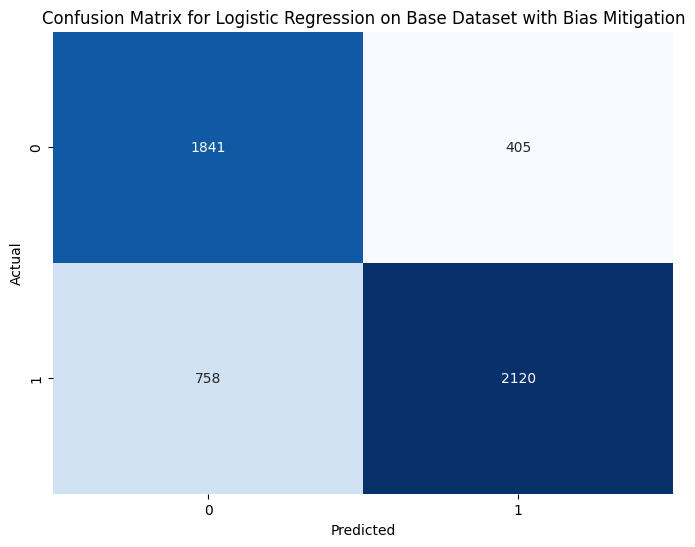

Classification Report for Logistic Regression on Base Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.71      0.82      0.76      2246
           1       0.84      0.74      0.78      2878

    accuracy                           0.77      5124
   macro avg       0.77      0.78      0.77      5124
weighted avg       0.78      0.77      0.77      5124

ROC-AUC Score for Logistic Regression on Base Dataset: 0.86

Training and Evaluating KNN on Base dataset with Bias Mitigation...


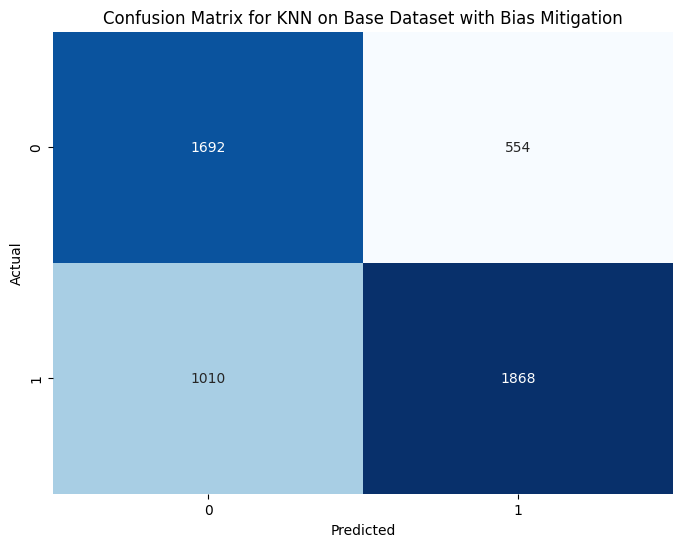

Classification Report for KNN on Base Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.63      0.75      0.68      2246
           1       0.77      0.65      0.70      2878

    accuracy                           0.69      5124
   macro avg       0.70      0.70      0.69      5124
weighted avg       0.71      0.69      0.70      5124

ROC-AUC Score for KNN on Base Dataset: 0.81

Training and Evaluating Random Forest on Base dataset with Bias Mitigation...


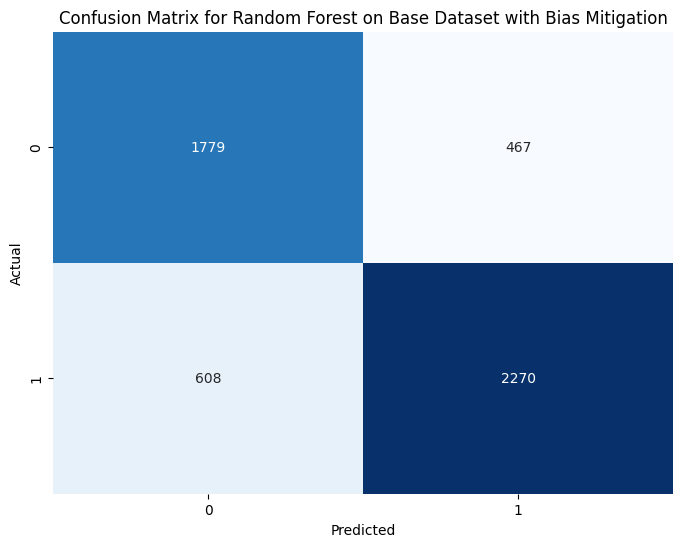

Classification Report for Random Forest on Base Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.75      0.79      0.77      2246
           1       0.83      0.79      0.81      2878

    accuracy                           0.79      5124
   macro avg       0.79      0.79      0.79      5124
weighted avg       0.79      0.79      0.79      5124

ROC-AUC Score for Random Forest on Base Dataset: 0.87

Training and Evaluating Gaussian Naive Bayes on Base dataset with Bias Mitigation...


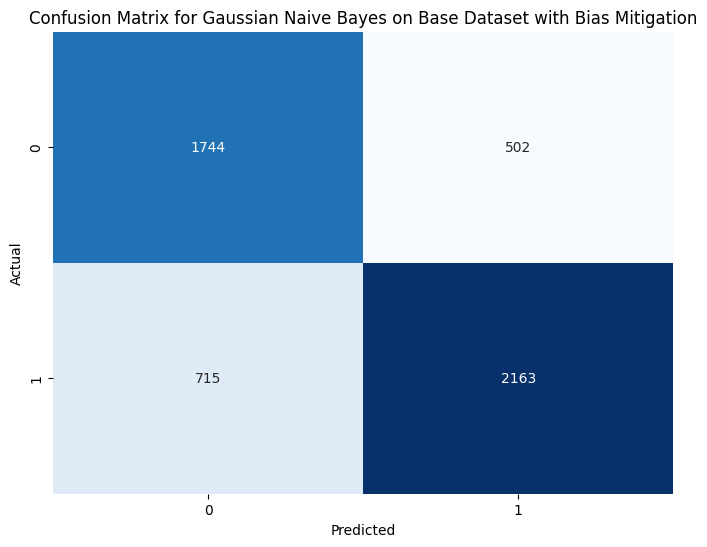

Classification Report for Gaussian Naive Bayes on Base Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.71      0.78      0.74      2246
           1       0.81      0.75      0.78      2878

    accuracy                           0.76      5124
   macro avg       0.76      0.76      0.76      5124
weighted avg       0.77      0.76      0.76      5124

ROC-AUC Score for Gaussian Naive Bayes on Base Dataset: 0.82

Training and Evaluating Bernoulli Naive Bayes on Base dataset with Bias Mitigation...


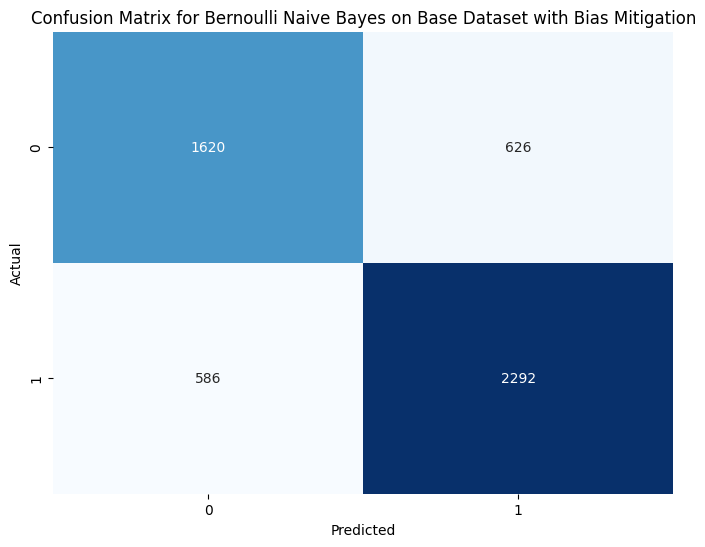

Classification Report for Bernoulli Naive Bayes on Base Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.73      0.72      0.73      2246
           1       0.79      0.80      0.79      2878

    accuracy                           0.76      5124
   macro avg       0.76      0.76      0.76      5124
weighted avg       0.76      0.76      0.76      5124

ROC-AUC Score for Bernoulli Naive Bayes on Base Dataset: 0.83

Training and Evaluating SVM on Base dataset with Bias Mitigation...


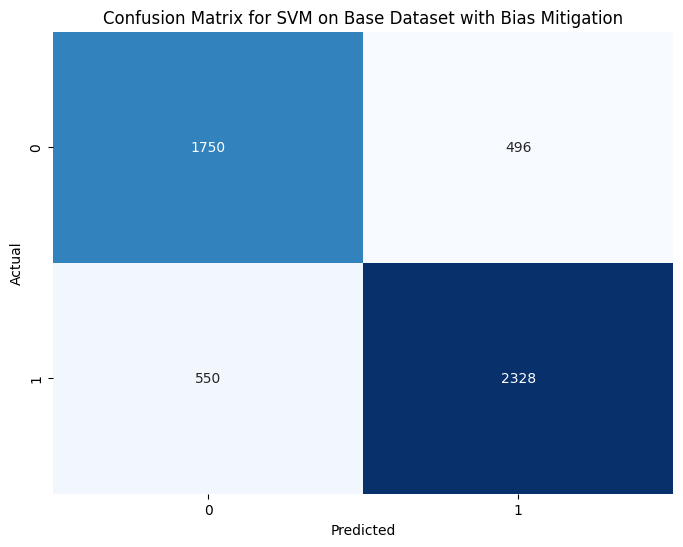

Classification Report for SVM on Base Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.76      0.78      0.77      2246
           1       0.82      0.81      0.82      2878

    accuracy                           0.80      5124
   macro avg       0.79      0.79      0.79      5124
weighted avg       0.80      0.80      0.80      5124

ROC-AUC Score for SVM on Base Dataset: 0.87

Training and Evaluating Neural Network on Base dataset with Bias Mitigation...
epoch 0; iter: 0; batch classifier loss: 0.703782; batch adversarial loss: 0.654570
epoch 1; iter: 0; batch classifier loss: 0.481116; batch adversarial loss: 0.676975
epoch 2; iter: 0; batch classifier loss: 0.403234; batch adversarial loss: 0.632917
epoch 3; iter: 0; batch classifier loss: 0.469246; batch adversarial loss: 0.628415
epoch 4; iter: 0; batch classifier loss: 0.467983; batch adversarial loss: 0.627897
epoch 5; iter: 0; batch classifier loss: 0.430335; batch adve

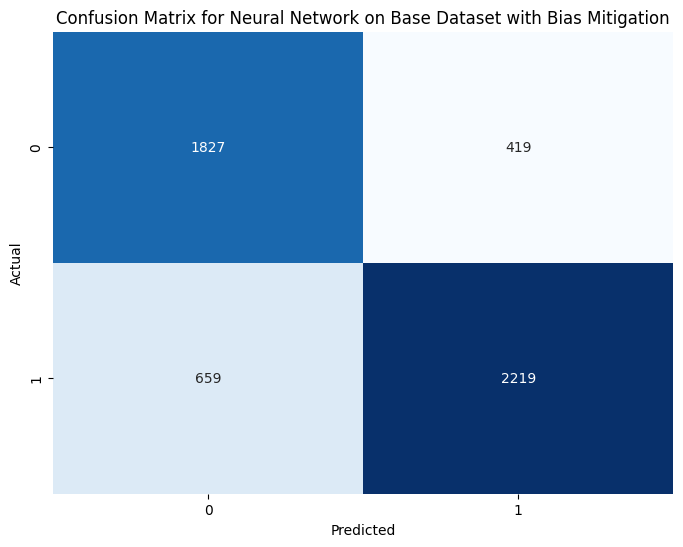

Classification Report for Neural Network on Base Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.73      0.81      0.77      2246
           1       0.84      0.77      0.80      2878

    accuracy                           0.79      5124
   macro avg       0.79      0.79      0.79      5124
weighted avg       0.79      0.79      0.79      5124

ROC-AUC Score for Neural Network on Base Dataset: Not Applicable

Training and Evaluating LightGBM on Base dataset with Bias Mitigation...
[LightGBM] [Info] Number of positive: 8783, number of negative: 8783
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3524
[LightGBM] [Info] Number of data points in the train set: 17566, number of used features: 28
[LightGBM] [Info] [binary:BoostFr

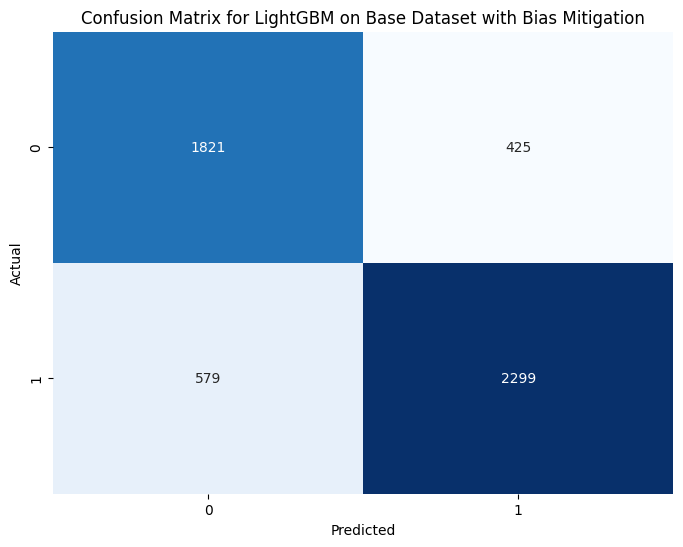

Classification Report for LightGBM on Base Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.76      0.81      0.78      2246
           1       0.84      0.80      0.82      2878

    accuracy                           0.80      5124
   macro avg       0.80      0.80      0.80      5124
weighted avg       0.81      0.80      0.80      5124

ROC-AUC Score for LightGBM on Base Dataset: 0.88

Training and Evaluating XGBoost on Base dataset with Bias Mitigation...


/opt/conda/lib/python3.10/site-packages/fairlearn/postprocessing/_interpolated_thresholder.py:154: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[9.98960863e-01 9.98960863e-01 9.98960863e-01 ... 9.98960863e-01
 5.35412327e-05 5.35412327e-05]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  positive_probs[sensitive_feature_vector == a] = interpolated_predictions[


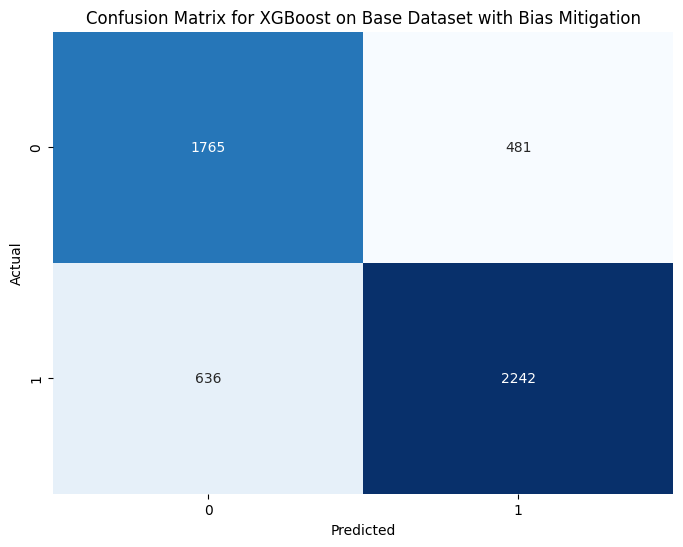

Classification Report for XGBoost on Base Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.74      0.79      0.76      2246
           1       0.82      0.78      0.80      2878

    accuracy                           0.78      5124
   macro avg       0.78      0.78      0.78      5124
weighted avg       0.78      0.78      0.78      5124

ROC-AUC Score for XGBoost on Base Dataset: 0.87

Processing Dataset: Variant I

Training and Evaluating Logistic Regression on Variant I dataset with Bias Mitigation...


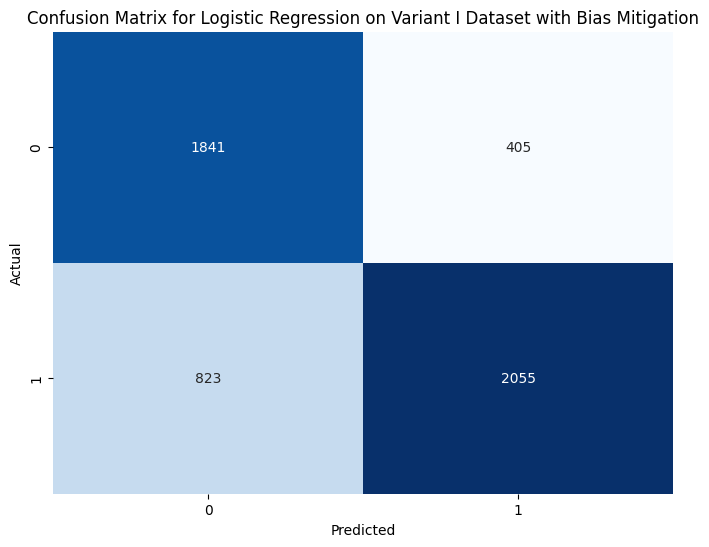

Classification Report for Logistic Regression on Variant I Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.69      0.82      0.75      2246
           1       0.84      0.71      0.77      2878

    accuracy                           0.76      5124
   macro avg       0.76      0.77      0.76      5124
weighted avg       0.77      0.76      0.76      5124

ROC-AUC Score for Logistic Regression on Variant I Dataset: 0.85

Training and Evaluating KNN on Variant I dataset with Bias Mitigation...


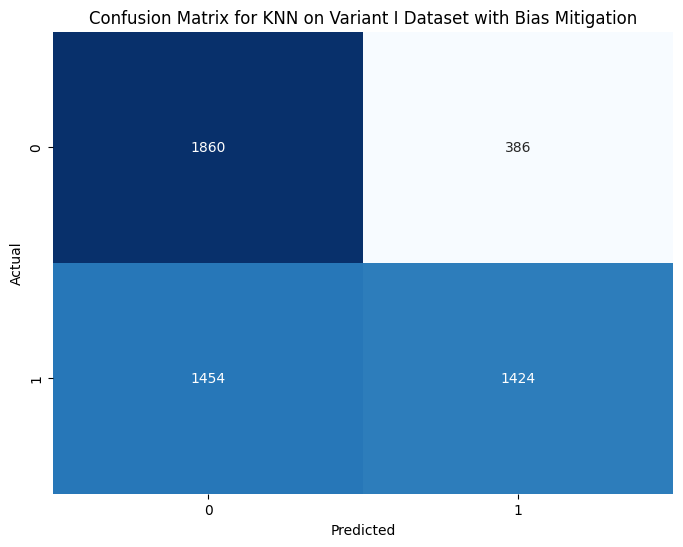

Classification Report for KNN on Variant I Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.56      0.83      0.67      2246
           1       0.79      0.49      0.61      2878

    accuracy                           0.64      5124
   macro avg       0.67      0.66      0.64      5124
weighted avg       0.69      0.64      0.63      5124

ROC-AUC Score for KNN on Variant I Dataset: 0.80

Training and Evaluating Random Forest on Variant I dataset with Bias Mitigation...


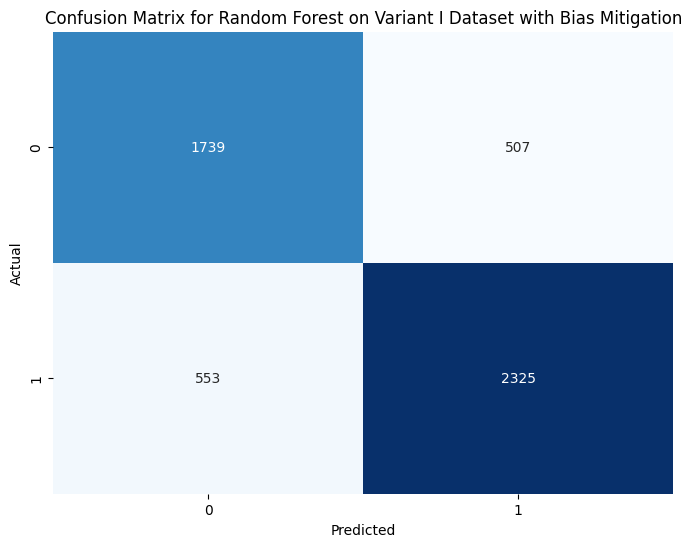

Classification Report for Random Forest on Variant I Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.76      0.77      0.77      2246
           1       0.82      0.81      0.81      2878

    accuracy                           0.79      5124
   macro avg       0.79      0.79      0.79      5124
weighted avg       0.79      0.79      0.79      5124

ROC-AUC Score for Random Forest on Variant I Dataset: 0.87

Training and Evaluating Gaussian Naive Bayes on Variant I dataset with Bias Mitigation...


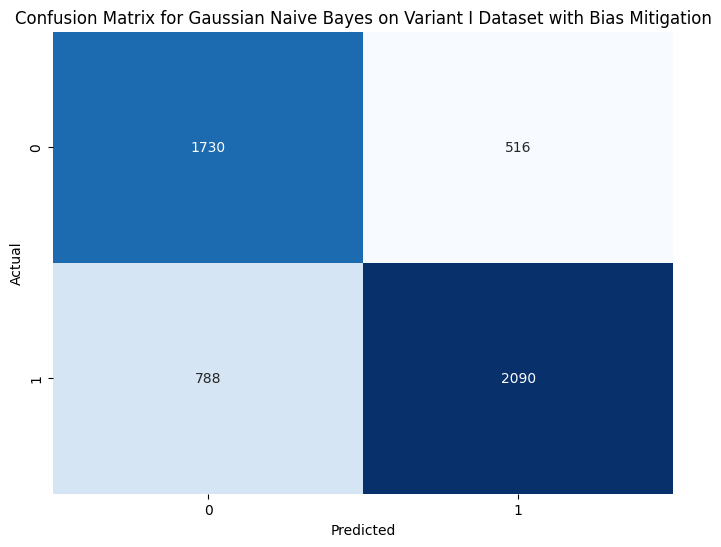

Classification Report for Gaussian Naive Bayes on Variant I Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.69      0.77      0.73      2246
           1       0.80      0.73      0.76      2878

    accuracy                           0.75      5124
   macro avg       0.74      0.75      0.74      5124
weighted avg       0.75      0.75      0.75      5124

ROC-AUC Score for Gaussian Naive Bayes on Variant I Dataset: 0.81

Training and Evaluating Bernoulli Naive Bayes on Variant I dataset with Bias Mitigation...


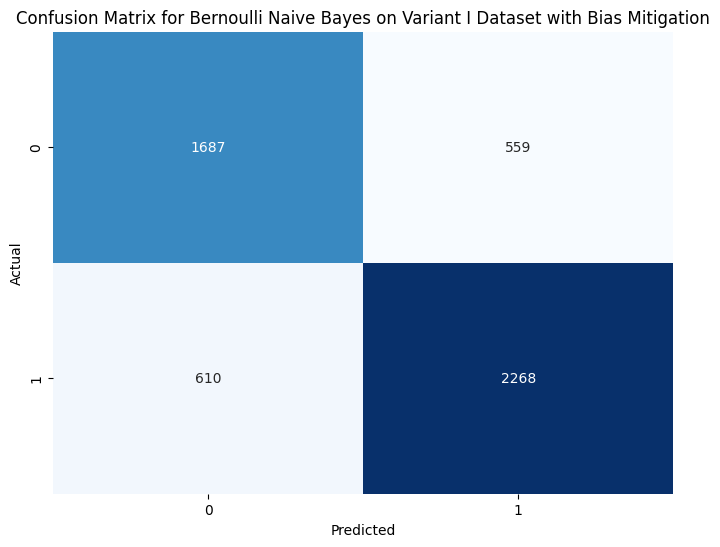

Classification Report for Bernoulli Naive Bayes on Variant I Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.73      0.75      0.74      2246
           1       0.80      0.79      0.80      2878

    accuracy                           0.77      5124
   macro avg       0.77      0.77      0.77      5124
weighted avg       0.77      0.77      0.77      5124

ROC-AUC Score for Bernoulli Naive Bayes on Variant I Dataset: 0.84

Training and Evaluating SVM on Variant I dataset with Bias Mitigation...


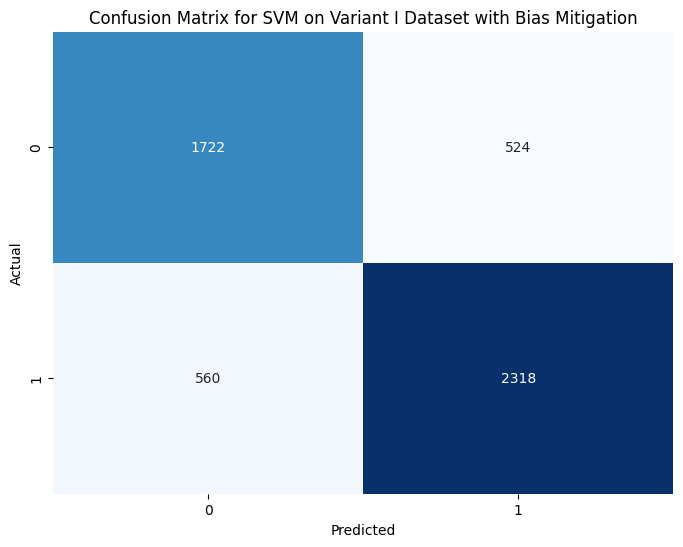

Classification Report for SVM on Variant I Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.75      0.77      0.76      2246
           1       0.82      0.81      0.81      2878

    accuracy                           0.79      5124
   macro avg       0.79      0.79      0.79      5124
weighted avg       0.79      0.79      0.79      5124

ROC-AUC Score for SVM on Variant I Dataset: 0.87

Training and Evaluating Neural Network on Variant I dataset with Bias Mitigation...
epoch 0; iter: 0; batch classifier loss: 0.722584; batch adversarial loss: 0.704230
epoch 1; iter: 0; batch classifier loss: 0.429881; batch adversarial loss: 0.677728
epoch 2; iter: 0; batch classifier loss: 0.443410; batch adversarial loss: 0.643395
epoch 3; iter: 0; batch classifier loss: 0.541217; batch adversarial loss: 0.714715
epoch 4; iter: 0; batch classifier loss: 0.463416; batch adversarial loss: 0.657514
epoch 5; iter: 0; batch classifier loss: 0.499

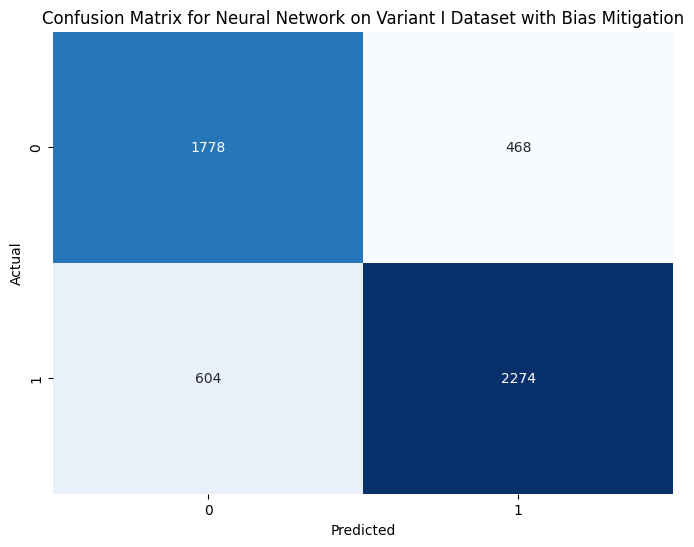

Classification Report for Neural Network on Variant I Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.75      0.79      0.77      2246
           1       0.83      0.79      0.81      2878

    accuracy                           0.79      5124
   macro avg       0.79      0.79      0.79      5124
weighted avg       0.79      0.79      0.79      5124

ROC-AUC Score for Neural Network on Variant I Dataset: Not Applicable

Training and Evaluating LightGBM on Variant I dataset with Bias Mitigation...
[LightGBM] [Info] Number of positive: 8783, number of negative: 8783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3515
[LightGBM] [Info] Number of data points in the train set: 17566, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.484772 -> initscore=-0.060932
[L

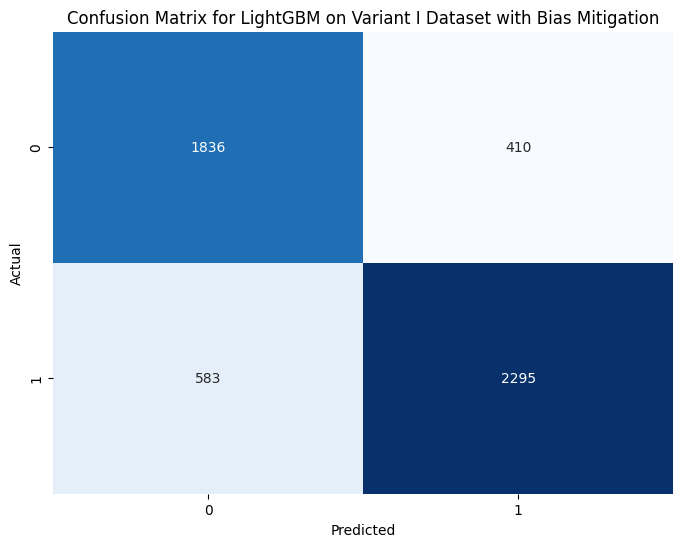

Classification Report for LightGBM on Variant I Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79      2246
           1       0.85      0.80      0.82      2878

    accuracy                           0.81      5124
   macro avg       0.80      0.81      0.80      5124
weighted avg       0.81      0.81      0.81      5124

ROC-AUC Score for LightGBM on Variant I Dataset: 0.89

Training and Evaluating XGBoost on Variant I dataset with Bias Mitigation...


/opt/conda/lib/python3.10/site-packages/fairlearn/postprocessing/_interpolated_thresholder.py:154: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.96121109 0.96121109 0.96121109 ... 0.96121109 0.00221417 0.00221417]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  positive_probs[sensitive_feature_vector == a] = interpolated_predictions[


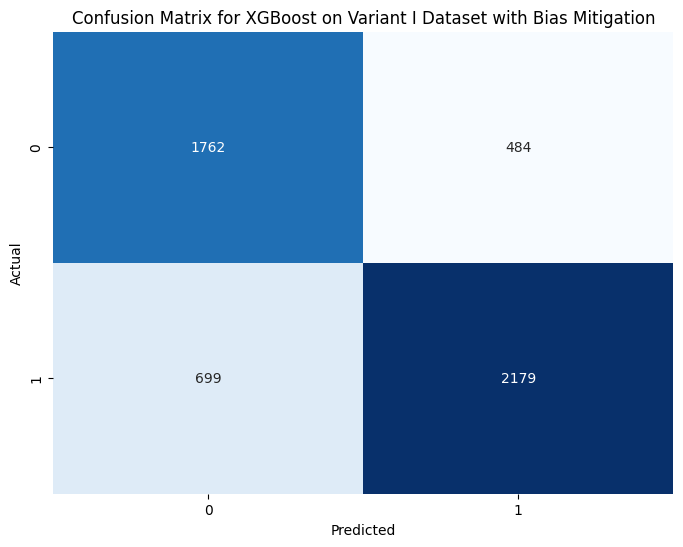

Classification Report for XGBoost on Variant I Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      2246
           1       0.82      0.76      0.79      2878

    accuracy                           0.77      5124
   macro avg       0.77      0.77      0.77      5124
weighted avg       0.77      0.77      0.77      5124

ROC-AUC Score for XGBoost on Variant I Dataset: 0.86

Processing Dataset: Variant II

Training and Evaluating Logistic Regression on Variant II dataset with Bias Mitigation...


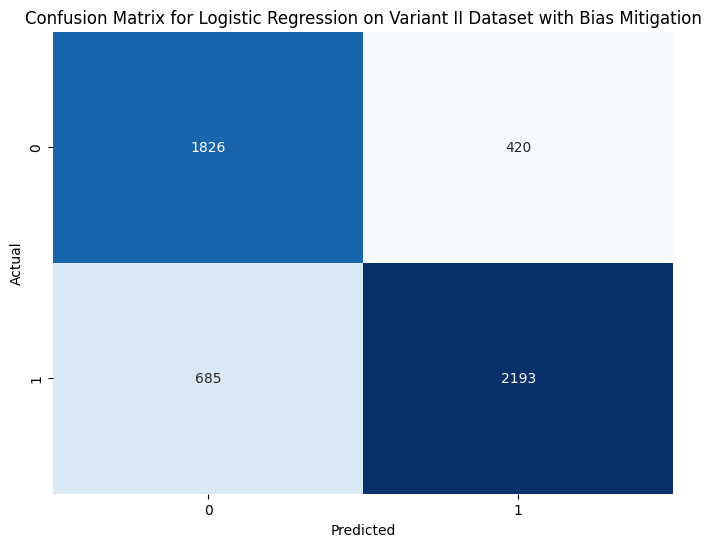

Classification Report for Logistic Regression on Variant II Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.73      0.81      0.77      2246
           1       0.84      0.76      0.80      2878

    accuracy                           0.78      5124
   macro avg       0.78      0.79      0.78      5124
weighted avg       0.79      0.78      0.79      5124

ROC-AUC Score for Logistic Regression on Variant II Dataset: 0.87

Training and Evaluating KNN on Variant II dataset with Bias Mitigation...


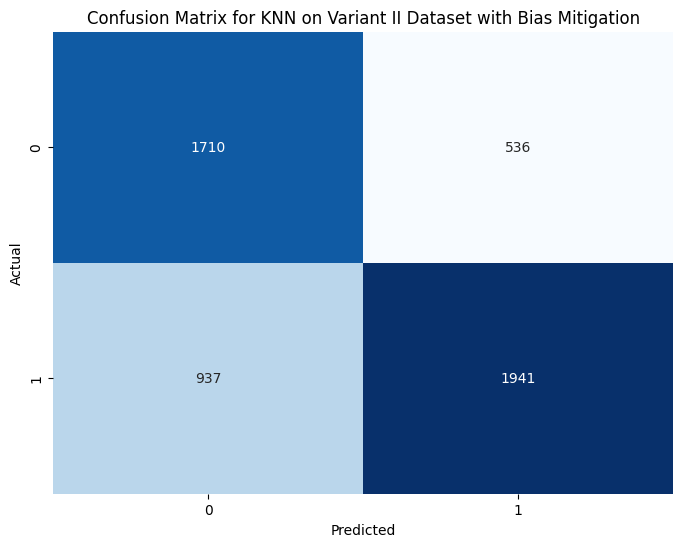

Classification Report for KNN on Variant II Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.65      0.76      0.70      2246
           1       0.78      0.67      0.72      2878

    accuracy                           0.71      5124
   macro avg       0.71      0.72      0.71      5124
weighted avg       0.72      0.71      0.71      5124

ROC-AUC Score for KNN on Variant II Dataset: 0.81

Training and Evaluating Random Forest on Variant II dataset with Bias Mitigation...


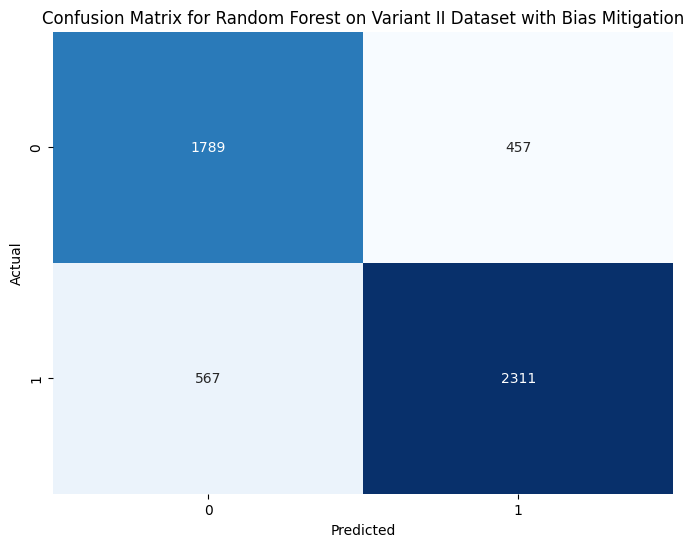

Classification Report for Random Forest on Variant II Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.76      0.80      0.78      2246
           1       0.83      0.80      0.82      2878

    accuracy                           0.80      5124
   macro avg       0.80      0.80      0.80      5124
weighted avg       0.80      0.80      0.80      5124

ROC-AUC Score for Random Forest on Variant II Dataset: 0.88

Training and Evaluating Gaussian Naive Bayes on Variant II dataset with Bias Mitigation...


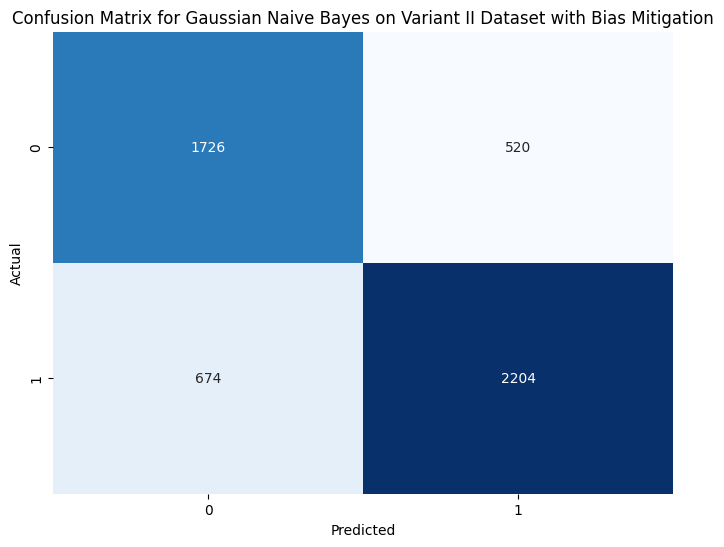

Classification Report for Gaussian Naive Bayes on Variant II Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.72      0.77      0.74      2246
           1       0.81      0.77      0.79      2878

    accuracy                           0.77      5124
   macro avg       0.76      0.77      0.76      5124
weighted avg       0.77      0.77      0.77      5124

ROC-AUC Score for Gaussian Naive Bayes on Variant II Dataset: 0.83

Training and Evaluating Bernoulli Naive Bayes on Variant II dataset with Bias Mitigation...


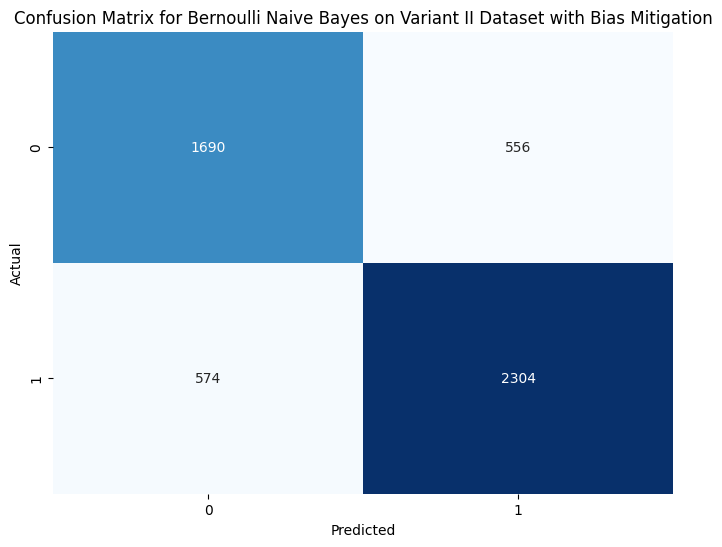

Classification Report for Bernoulli Naive Bayes on Variant II Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      2246
           1       0.81      0.80      0.80      2878

    accuracy                           0.78      5124
   macro avg       0.78      0.78      0.78      5124
weighted avg       0.78      0.78      0.78      5124

ROC-AUC Score for Bernoulli Naive Bayes on Variant II Dataset: 0.85

Training and Evaluating SVM on Variant II dataset with Bias Mitigation...


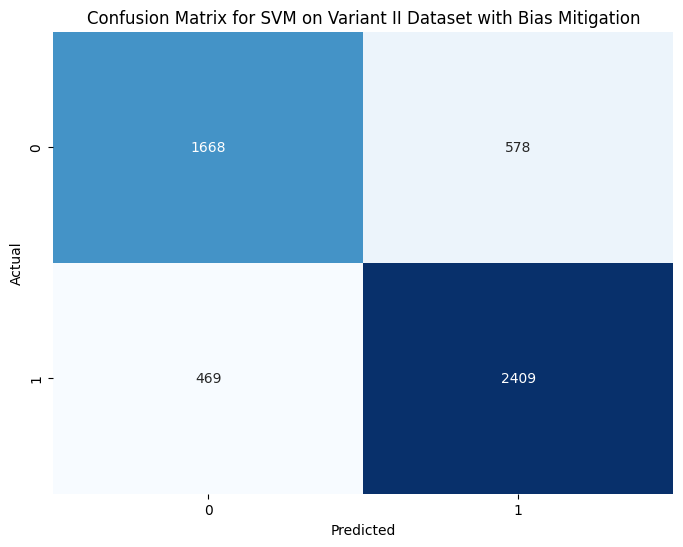

Classification Report for SVM on Variant II Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.78      0.74      0.76      2246
           1       0.81      0.84      0.82      2878

    accuracy                           0.80      5124
   macro avg       0.79      0.79      0.79      5124
weighted avg       0.80      0.80      0.80      5124

ROC-AUC Score for SVM on Variant II Dataset: 0.87

Training and Evaluating Neural Network on Variant II dataset with Bias Mitigation...
epoch 0; iter: 0; batch classifier loss: 0.785221; batch adversarial loss: 0.716232
epoch 1; iter: 0; batch classifier loss: 0.461626; batch adversarial loss: 0.691509
epoch 2; iter: 0; batch classifier loss: 0.406595; batch adversarial loss: 0.701153
epoch 3; iter: 0; batch classifier loss: 0.459822; batch adversarial loss: 0.745030
epoch 4; iter: 0; batch classifier loss: 0.342843; batch adversarial loss: 0.652658
epoch 5; iter: 0; batch classifier loss: 0.

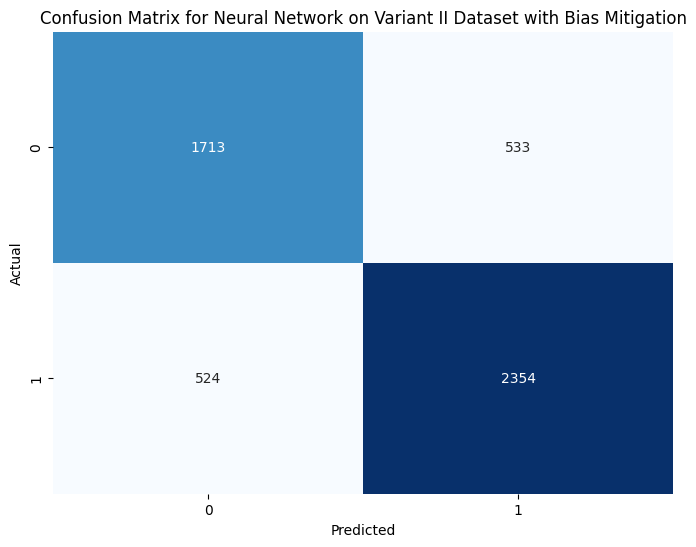

Classification Report for Neural Network on Variant II Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.77      0.76      0.76      2246
           1       0.82      0.82      0.82      2878

    accuracy                           0.79      5124
   macro avg       0.79      0.79      0.79      5124
weighted avg       0.79      0.79      0.79      5124

ROC-AUC Score for Neural Network on Variant II Dataset: Not Applicable

Training and Evaluating LightGBM on Variant II dataset with Bias Mitigation...
[LightGBM] [Info] Number of positive: 8783, number of negative: 8783
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3520
[LightGBM] [Info] Number of data points in the train set: 17566, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.501195 -> initscore=0.004782


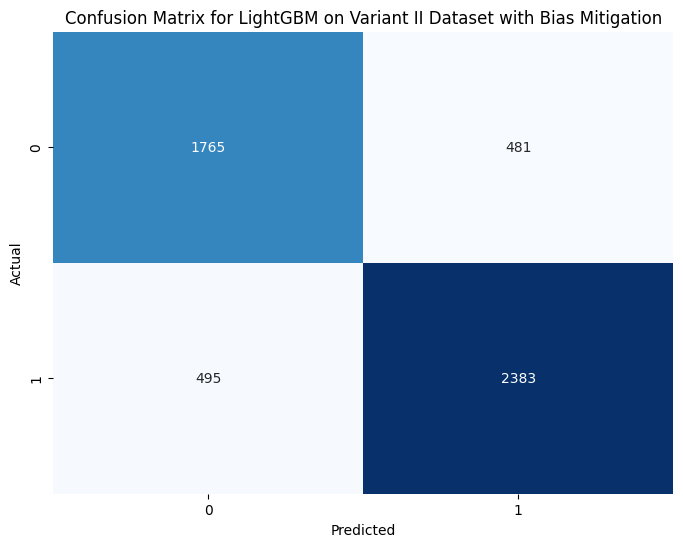

Classification Report for LightGBM on Variant II Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.78      0.79      0.78      2246
           1       0.83      0.83      0.83      2878

    accuracy                           0.81      5124
   macro avg       0.81      0.81      0.81      5124
weighted avg       0.81      0.81      0.81      5124

ROC-AUC Score for LightGBM on Variant II Dataset: 0.89

Training and Evaluating XGBoost on Variant II dataset with Bias Mitigation...


/opt/conda/lib/python3.10/site-packages/fairlearn/postprocessing/_interpolated_thresholder.py:154: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.98228424 0.98228424 0.00099148 ... 0.98228424 0.98228424 0.00099148]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  positive_probs[sensitive_feature_vector == a] = interpolated_predictions[


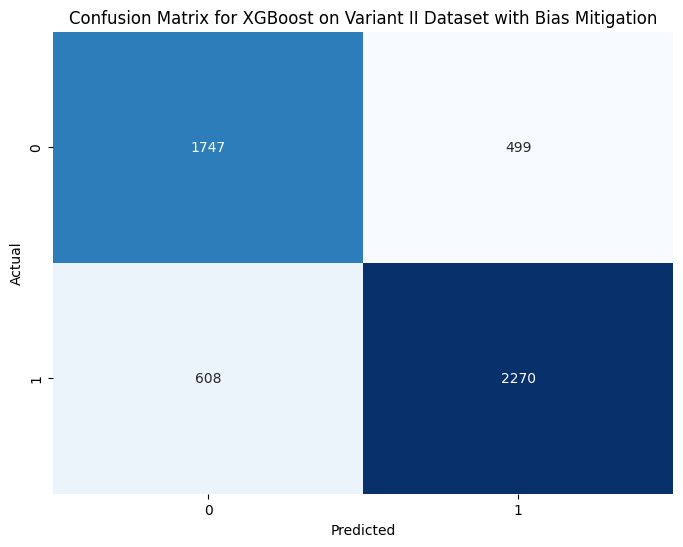

Classification Report for XGBoost on Variant II Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.74      0.78      0.76      2246
           1       0.82      0.79      0.80      2878

    accuracy                           0.78      5124
   macro avg       0.78      0.78      0.78      5124
weighted avg       0.79      0.78      0.78      5124

ROC-AUC Score for XGBoost on Variant II Dataset: 0.88

Processing Dataset: Variant III

Training and Evaluating Logistic Regression on Variant III dataset with Bias Mitigation...


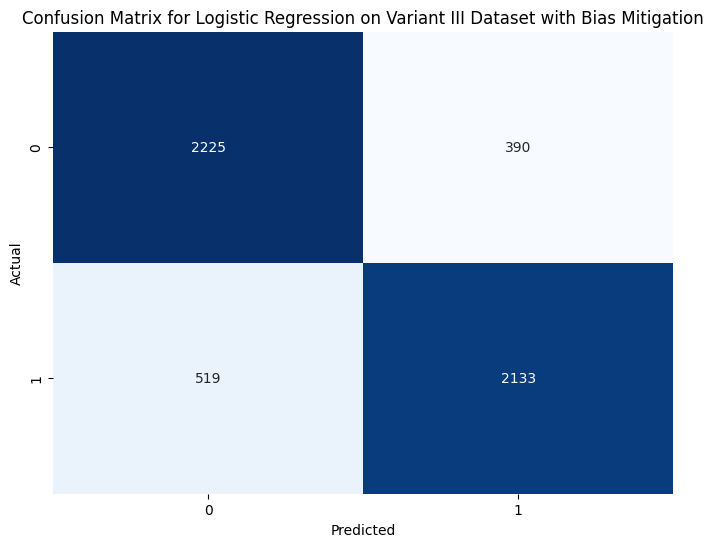

Classification Report for Logistic Regression on Variant III Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      2615
           1       0.85      0.80      0.82      2652

    accuracy                           0.83      5267
   macro avg       0.83      0.83      0.83      5267
weighted avg       0.83      0.83      0.83      5267

ROC-AUC Score for Logistic Regression on Variant III Dataset: 0.91

Training and Evaluating KNN on Variant III dataset with Bias Mitigation...


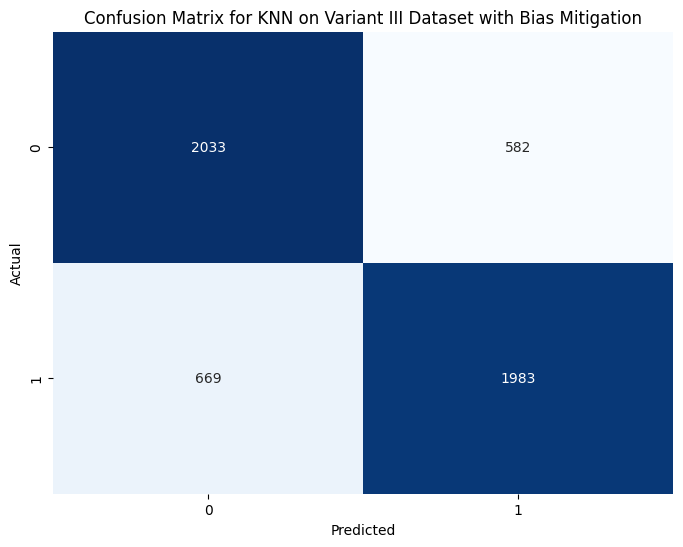

Classification Report for KNN on Variant III Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.75      0.78      0.76      2615
           1       0.77      0.75      0.76      2652

    accuracy                           0.76      5267
   macro avg       0.76      0.76      0.76      5267
weighted avg       0.76      0.76      0.76      5267

ROC-AUC Score for KNN on Variant III Dataset: 0.88

Training and Evaluating Random Forest on Variant III dataset with Bias Mitigation...


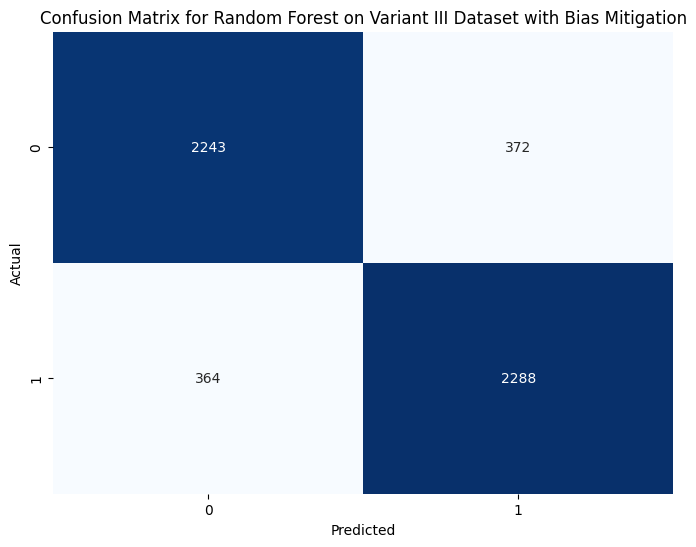

Classification Report for Random Forest on Variant III Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      2615
           1       0.86      0.86      0.86      2652

    accuracy                           0.86      5267
   macro avg       0.86      0.86      0.86      5267
weighted avg       0.86      0.86      0.86      5267

ROC-AUC Score for Random Forest on Variant III Dataset: 0.94

Training and Evaluating Gaussian Naive Bayes on Variant III dataset with Bias Mitigation...


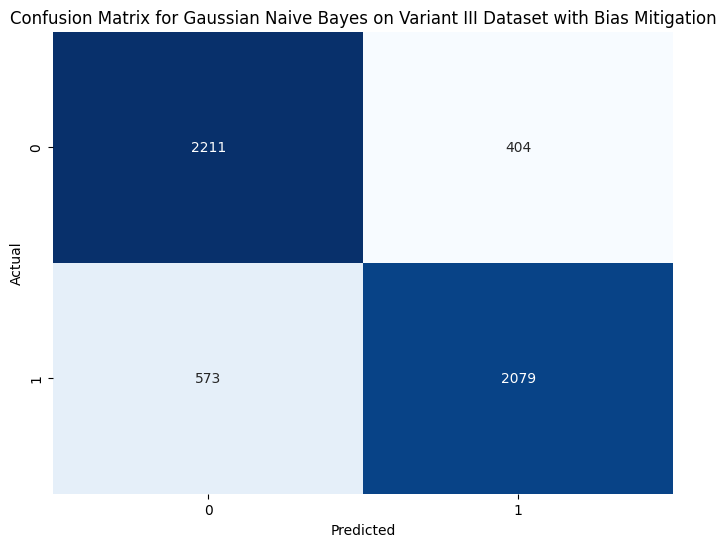

Classification Report for Gaussian Naive Bayes on Variant III Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.79      0.85      0.82      2615
           1       0.84      0.78      0.81      2652

    accuracy                           0.81      5267
   macro avg       0.82      0.81      0.81      5267
weighted avg       0.82      0.81      0.81      5267

ROC-AUC Score for Gaussian Naive Bayes on Variant III Dataset: 0.88

Training and Evaluating Bernoulli Naive Bayes on Variant III dataset with Bias Mitigation...


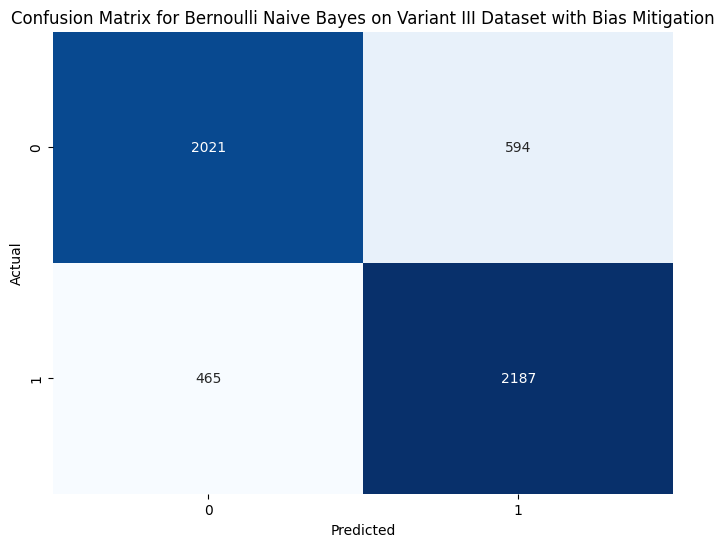

Classification Report for Bernoulli Naive Bayes on Variant III Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.81      0.77      0.79      2615
           1       0.79      0.82      0.81      2652

    accuracy                           0.80      5267
   macro avg       0.80      0.80      0.80      5267
weighted avg       0.80      0.80      0.80      5267

ROC-AUC Score for Bernoulli Naive Bayes on Variant III Dataset: 0.88

Training and Evaluating SVM on Variant III dataset with Bias Mitigation...


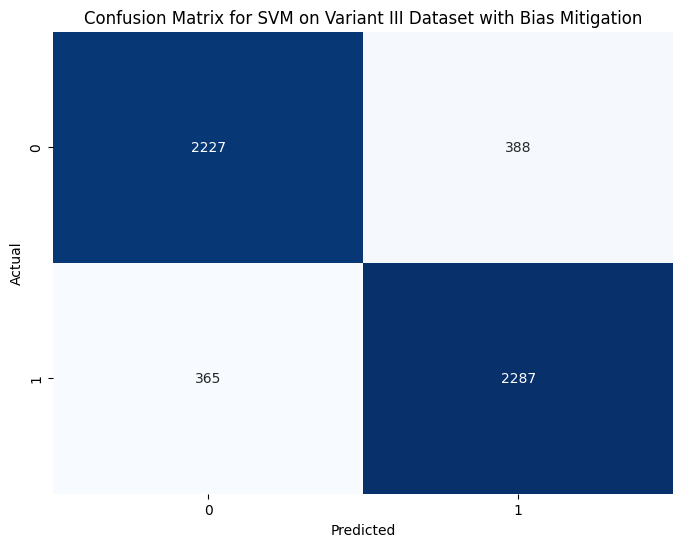

Classification Report for SVM on Variant III Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      2615
           1       0.85      0.86      0.86      2652

    accuracy                           0.86      5267
   macro avg       0.86      0.86      0.86      5267
weighted avg       0.86      0.86      0.86      5267

ROC-AUC Score for SVM on Variant III Dataset: 0.93

Training and Evaluating Neural Network on Variant III dataset with Bias Mitigation...
epoch 0; iter: 0; batch classifier loss: 0.707541; batch adversarial loss: 0.726549
epoch 1; iter: 0; batch classifier loss: 0.321271; batch adversarial loss: 0.680277
epoch 2; iter: 0; batch classifier loss: 0.318525; batch adversarial loss: 0.680639
epoch 3; iter: 0; batch classifier loss: 0.364900; batch adversarial loss: 0.626892
epoch 4; iter: 0; batch classifier loss: 0.315823; batch adversarial loss: 0.646634
epoch 5; iter: 0; batch classifier loss:

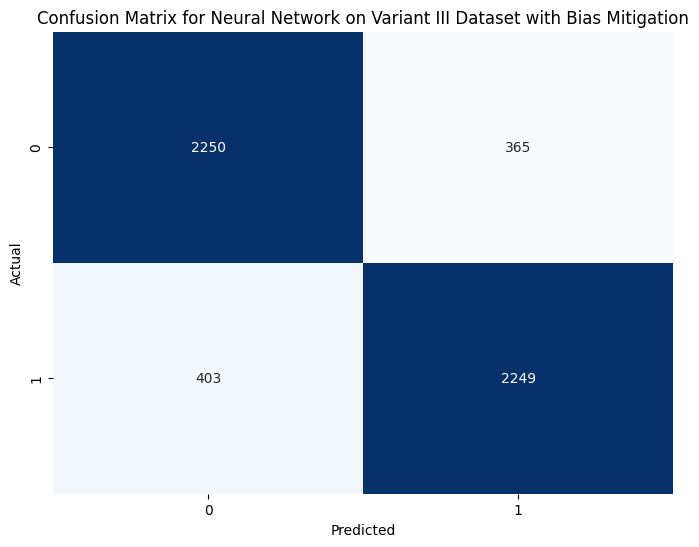

Classification Report for Neural Network on Variant III Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      2615
           1       0.86      0.85      0.85      2652

    accuracy                           0.85      5267
   macro avg       0.85      0.85      0.85      5267
weighted avg       0.85      0.85      0.85      5267

ROC-AUC Score for Neural Network on Variant III Dataset: Not Applicable

Training and Evaluating LightGBM on Variant III dataset with Bias Mitigation...
[LightGBM] [Info] Number of positive: 8415, number of negative: 8415
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3701
[LightGBM] [Info] Number of data points in the train set: 16830, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.485146 -> initscore=-0.059

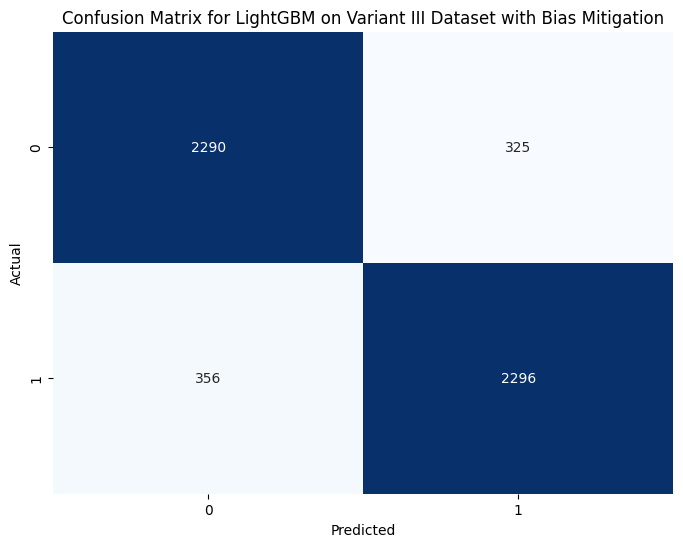

Classification Report for LightGBM on Variant III Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      2615
           1       0.88      0.87      0.87      2652

    accuracy                           0.87      5267
   macro avg       0.87      0.87      0.87      5267
weighted avg       0.87      0.87      0.87      5267

ROC-AUC Score for LightGBM on Variant III Dataset: 0.95

Training and Evaluating XGBoost on Variant III dataset with Bias Mitigation...


/opt/conda/lib/python3.10/site-packages/fairlearn/postprocessing/_interpolated_thresholder.py:154: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.14882739e-04 9.89470746e-01 9.89470746e-01 ... 9.89470746e-01
 9.89470746e-01 2.14882739e-04]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  positive_probs[sensitive_feature_vector == a] = interpolated_predictions[


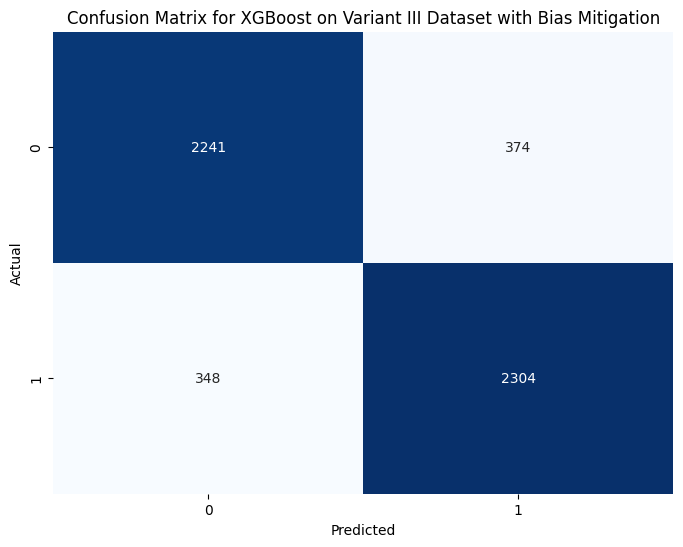

Classification Report for XGBoost on Variant III Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      2615
           1       0.86      0.87      0.86      2652

    accuracy                           0.86      5267
   macro avg       0.86      0.86      0.86      5267
weighted avg       0.86      0.86      0.86      5267

ROC-AUC Score for XGBoost on Variant III Dataset: 0.94

Processing Dataset: Variant IV

Training and Evaluating Logistic Regression on Variant IV dataset with Bias Mitigation...


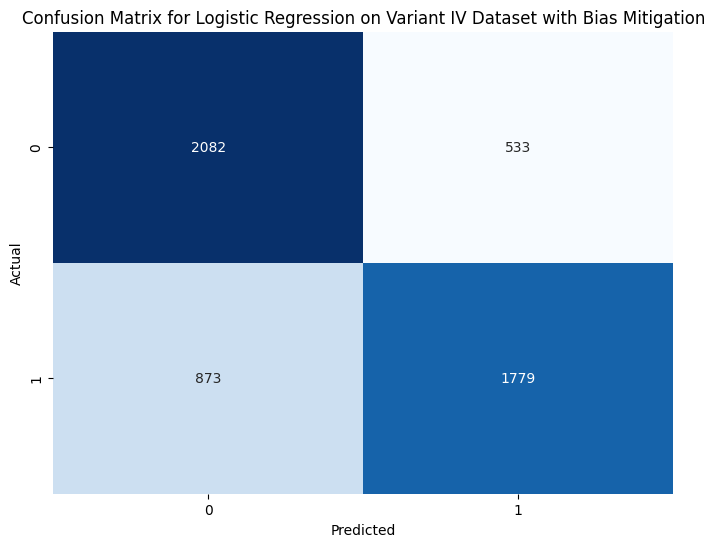

Classification Report for Logistic Regression on Variant IV Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.70      0.80      0.75      2615
           1       0.77      0.67      0.72      2652

    accuracy                           0.73      5267
   macro avg       0.74      0.73      0.73      5267
weighted avg       0.74      0.73      0.73      5267

ROC-AUC Score for Logistic Regression on Variant IV Dataset: 0.81

Training and Evaluating KNN on Variant IV dataset with Bias Mitigation...


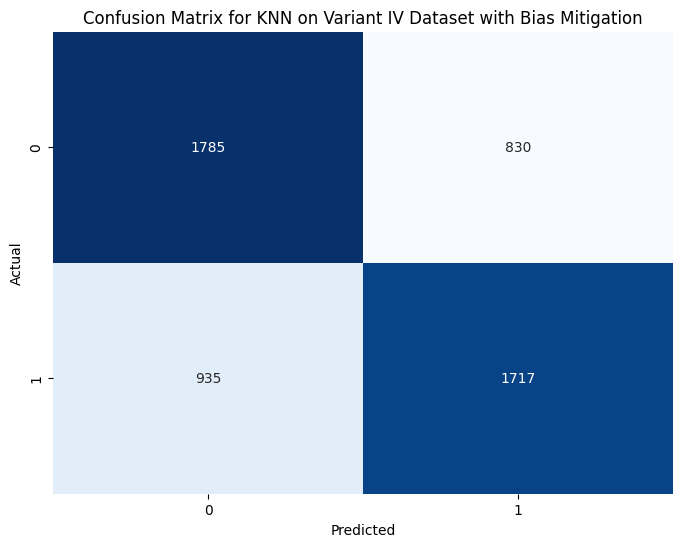

Classification Report for KNN on Variant IV Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.66      0.68      0.67      2615
           1       0.67      0.65      0.66      2652

    accuracy                           0.66      5267
   macro avg       0.67      0.67      0.66      5267
weighted avg       0.67      0.66      0.66      5267

ROC-AUC Score for KNN on Variant IV Dataset: 0.77

Training and Evaluating Random Forest on Variant IV dataset with Bias Mitigation...


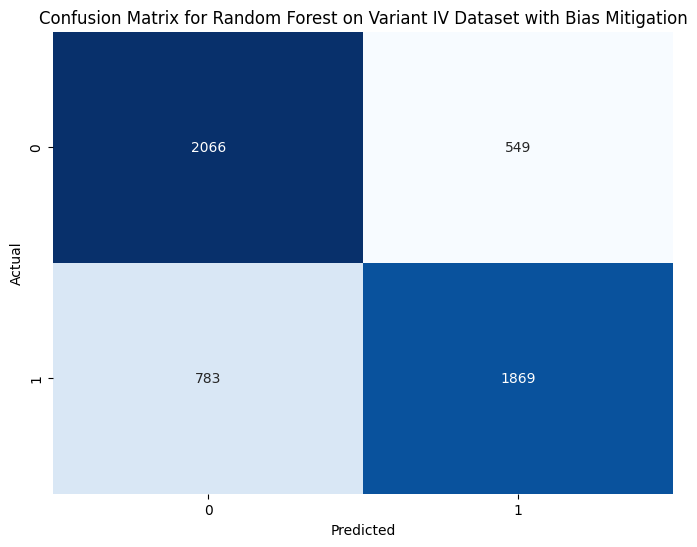

Classification Report for Random Forest on Variant IV Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.73      0.79      0.76      2615
           1       0.77      0.70      0.74      2652

    accuracy                           0.75      5267
   macro avg       0.75      0.75      0.75      5267
weighted avg       0.75      0.75      0.75      5267

ROC-AUC Score for Random Forest on Variant IV Dataset: 0.82

Training and Evaluating Gaussian Naive Bayes on Variant IV dataset with Bias Mitigation...


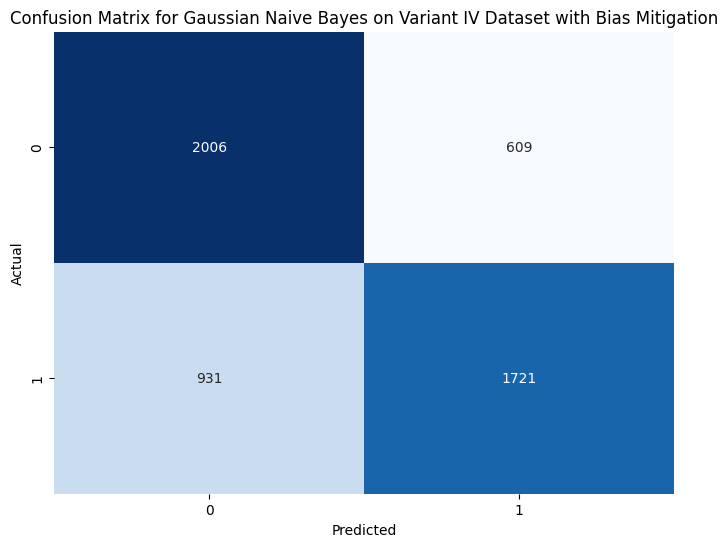

Classification Report for Gaussian Naive Bayes on Variant IV Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.68      0.77      0.72      2615
           1       0.74      0.65      0.69      2652

    accuracy                           0.71      5267
   macro avg       0.71      0.71      0.71      5267
weighted avg       0.71      0.71      0.71      5267

ROC-AUC Score for Gaussian Naive Bayes on Variant IV Dataset: 0.77

Training and Evaluating Bernoulli Naive Bayes on Variant IV dataset with Bias Mitigation...


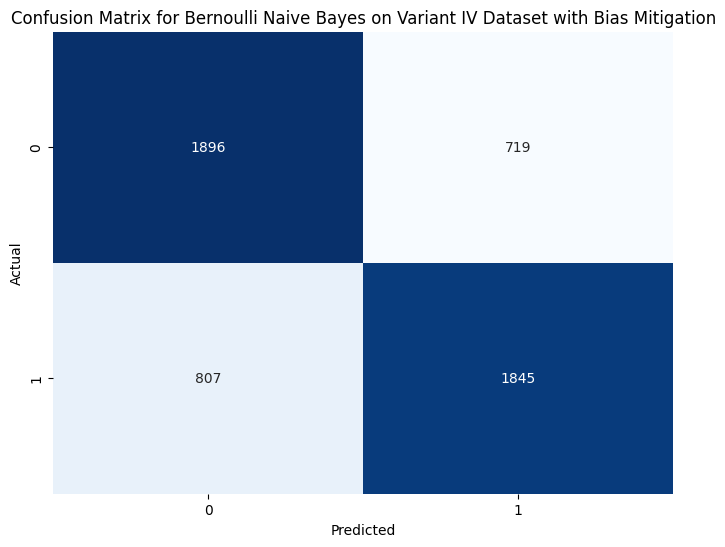

Classification Report for Bernoulli Naive Bayes on Variant IV Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.70      0.73      0.71      2615
           1       0.72      0.70      0.71      2652

    accuracy                           0.71      5267
   macro avg       0.71      0.71      0.71      5267
weighted avg       0.71      0.71      0.71      5267

ROC-AUC Score for Bernoulli Naive Bayes on Variant IV Dataset: 0.78

Training and Evaluating SVM on Variant IV dataset with Bias Mitigation...


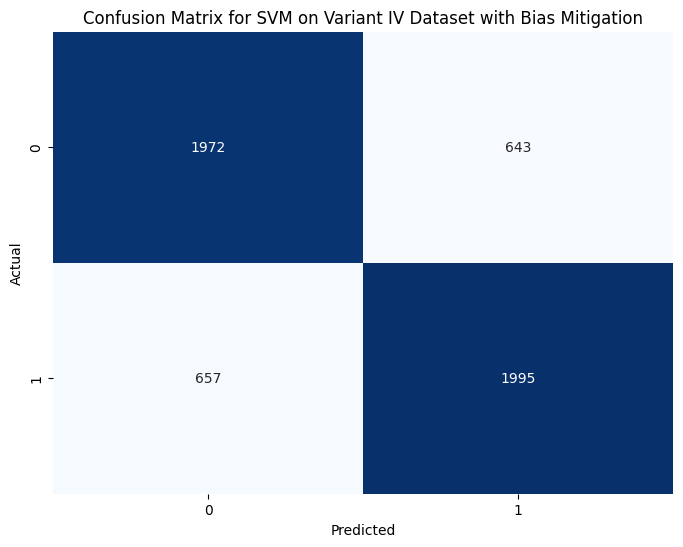

Classification Report for SVM on Variant IV Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      2615
           1       0.76      0.75      0.75      2652

    accuracy                           0.75      5267
   macro avg       0.75      0.75      0.75      5267
weighted avg       0.75      0.75      0.75      5267

ROC-AUC Score for SVM on Variant IV Dataset: 0.83

Training and Evaluating Neural Network on Variant IV dataset with Bias Mitigation...
epoch 0; iter: 0; batch classifier loss: 0.781673; batch adversarial loss: 0.686691
epoch 1; iter: 0; batch classifier loss: 0.511680; batch adversarial loss: 0.687302
epoch 2; iter: 0; batch classifier loss: 0.543778; batch adversarial loss: 0.717532
epoch 3; iter: 0; batch classifier loss: 0.367807; batch adversarial loss: 0.637870
epoch 4; iter: 0; batch classifier loss: 0.391735; batch adversarial loss: 0.671535
epoch 5; iter: 0; batch classifier loss: 0.

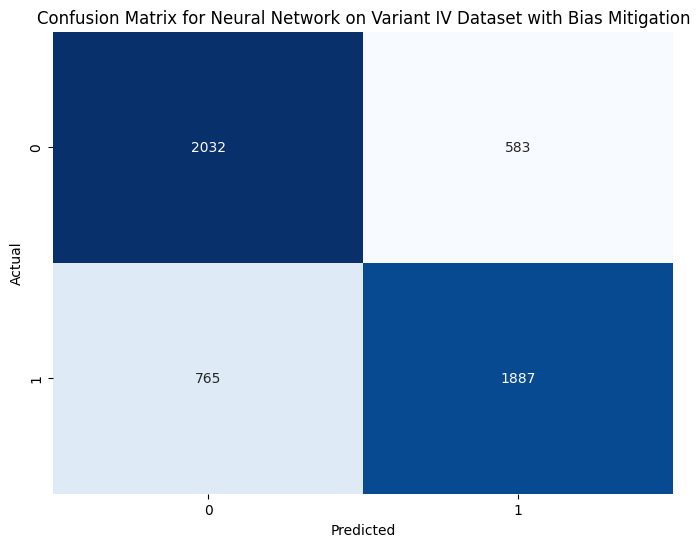

Classification Report for Neural Network on Variant IV Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.73      0.78      0.75      2615
           1       0.76      0.71      0.74      2652

    accuracy                           0.74      5267
   macro avg       0.75      0.74      0.74      5267
weighted avg       0.75      0.74      0.74      5267

ROC-AUC Score for Neural Network on Variant IV Dataset: Not Applicable

Training and Evaluating LightGBM on Variant IV dataset with Bias Mitigation...
[LightGBM] [Info] Number of positive: 8415, number of negative: 8415
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3190
[LightGBM] [Info] Number of data points in the train set: 16830, number of used features: 28
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499228 -> initscore=-0.003090

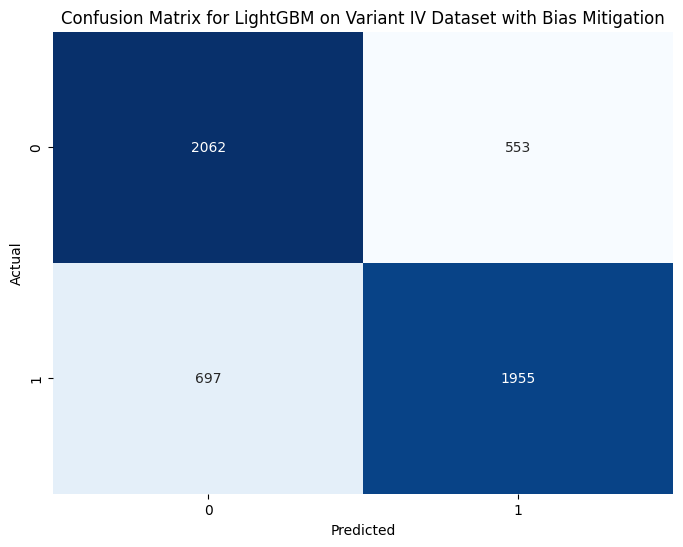

Classification Report for LightGBM on Variant IV Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.75      0.79      0.77      2615
           1       0.78      0.74      0.76      2652

    accuracy                           0.76      5267
   macro avg       0.76      0.76      0.76      5267
weighted avg       0.76      0.76      0.76      5267

ROC-AUC Score for LightGBM on Variant IV Dataset: 0.84

Training and Evaluating XGBoost on Variant IV dataset with Bias Mitigation...


/opt/conda/lib/python3.10/site-packages/fairlearn/postprocessing/_interpolated_thresholder.py:154: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[5.23934752e-06 9.99863635e-01 9.99863635e-01 ... 5.23934752e-06
 5.23934752e-06 5.23934752e-06]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  positive_probs[sensitive_feature_vector == a] = interpolated_predictions[


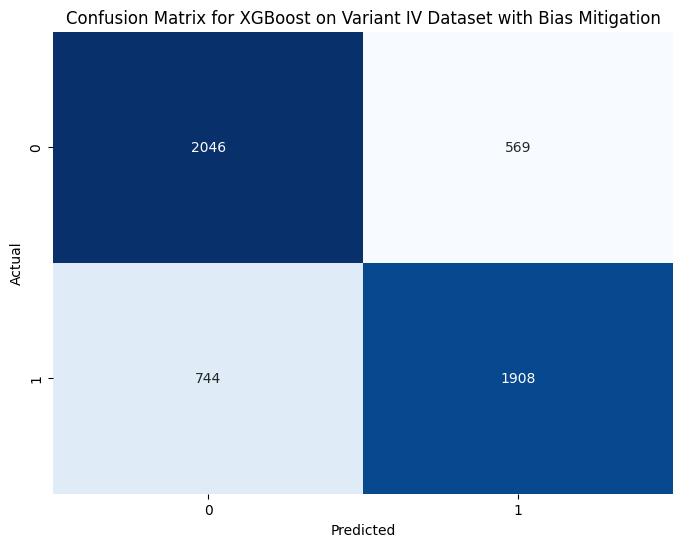

Classification Report for XGBoost on Variant IV Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.73      0.78      0.76      2615
           1       0.77      0.72      0.74      2652

    accuracy                           0.75      5267
   macro avg       0.75      0.75      0.75      5267
weighted avg       0.75      0.75      0.75      5267

ROC-AUC Score for XGBoost on Variant IV Dataset: 0.83

Processing Dataset: Variant V

Training and Evaluating Logistic Regression on Variant V dataset with Bias Mitigation...


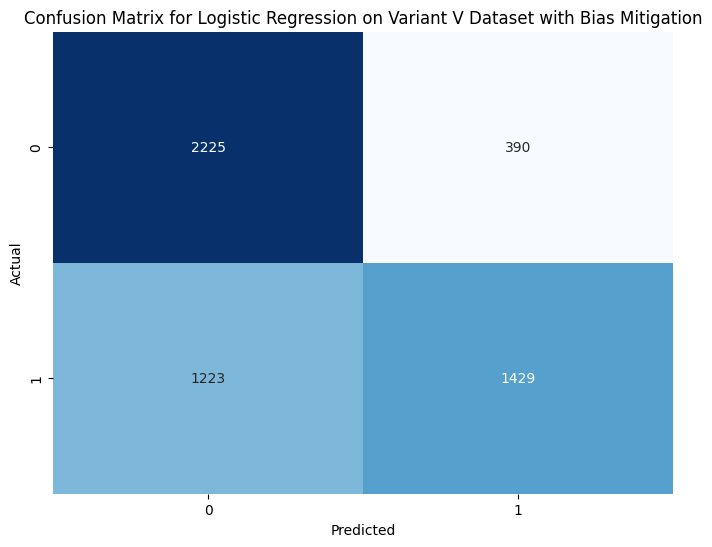

Classification Report for Logistic Regression on Variant V Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.65      0.85      0.73      2615
           1       0.79      0.54      0.64      2652

    accuracy                           0.69      5267
   macro avg       0.72      0.69      0.69      5267
weighted avg       0.72      0.69      0.69      5267

ROC-AUC Score for Logistic Regression on Variant V Dataset: 0.78

Training and Evaluating KNN on Variant V dataset with Bias Mitigation...


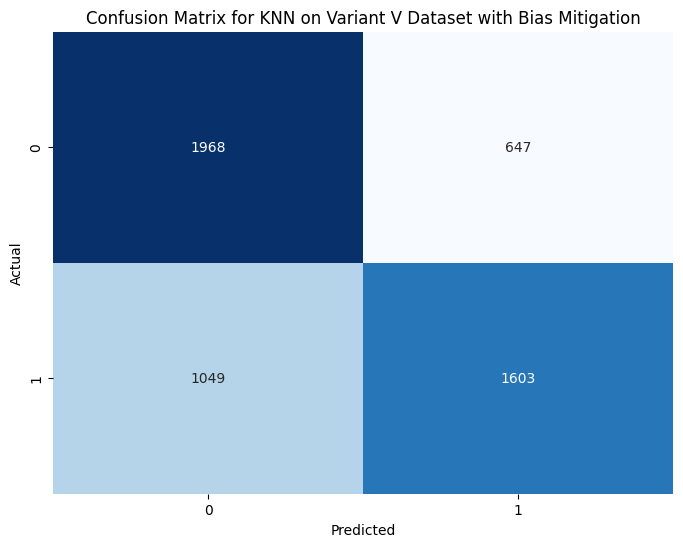

Classification Report for KNN on Variant V Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.65      0.75      0.70      2615
           1       0.71      0.60      0.65      2652

    accuracy                           0.68      5267
   macro avg       0.68      0.68      0.68      5267
weighted avg       0.68      0.68      0.68      5267

ROC-AUC Score for KNN on Variant V Dataset: 0.77

Training and Evaluating Random Forest on Variant V dataset with Bias Mitigation...


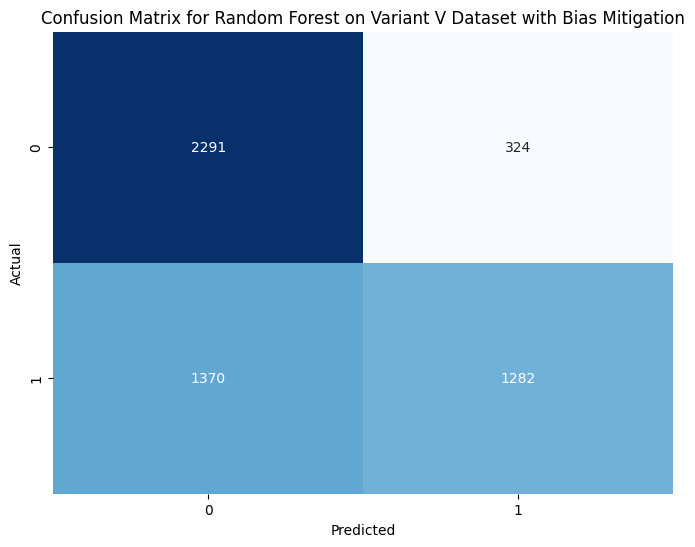

Classification Report for Random Forest on Variant V Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.63      0.88      0.73      2615
           1       0.80      0.48      0.60      2652

    accuracy                           0.68      5267
   macro avg       0.71      0.68      0.67      5267
weighted avg       0.71      0.68      0.67      5267

ROC-AUC Score for Random Forest on Variant V Dataset: 0.78

Training and Evaluating Gaussian Naive Bayes on Variant V dataset with Bias Mitigation...


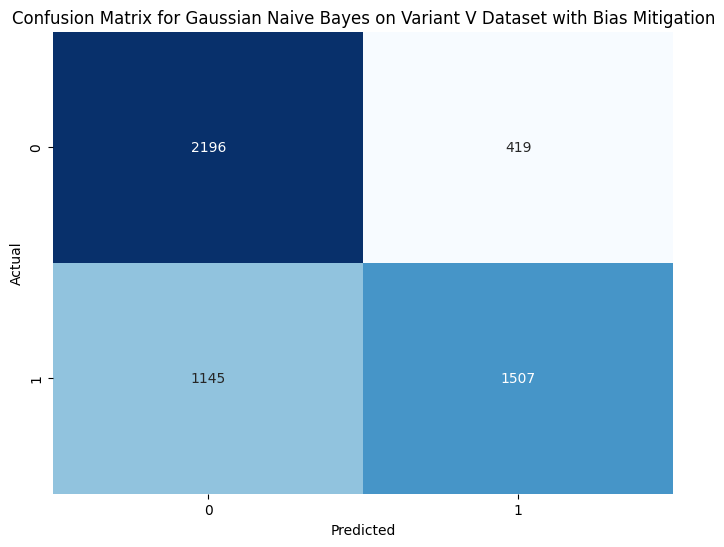

Classification Report for Gaussian Naive Bayes on Variant V Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.66      0.84      0.74      2615
           1       0.78      0.57      0.66      2652

    accuracy                           0.70      5267
   macro avg       0.72      0.70      0.70      5267
weighted avg       0.72      0.70      0.70      5267

ROC-AUC Score for Gaussian Naive Bayes on Variant V Dataset: 0.78

Training and Evaluating Bernoulli Naive Bayes on Variant V dataset with Bias Mitigation...


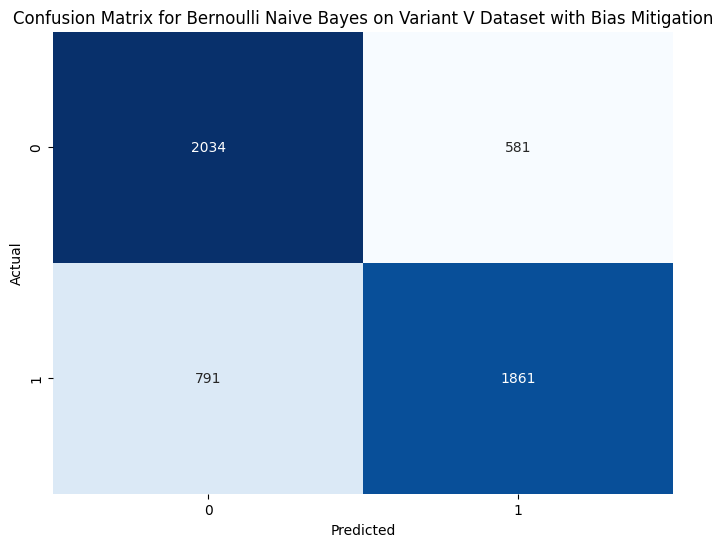

Classification Report for Bernoulli Naive Bayes on Variant V Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      2615
           1       0.76      0.70      0.73      2652

    accuracy                           0.74      5267
   macro avg       0.74      0.74      0.74      5267
weighted avg       0.74      0.74      0.74      5267

ROC-AUC Score for Bernoulli Naive Bayes on Variant V Dataset: 0.81

Training and Evaluating SVM on Variant V dataset with Bias Mitigation...


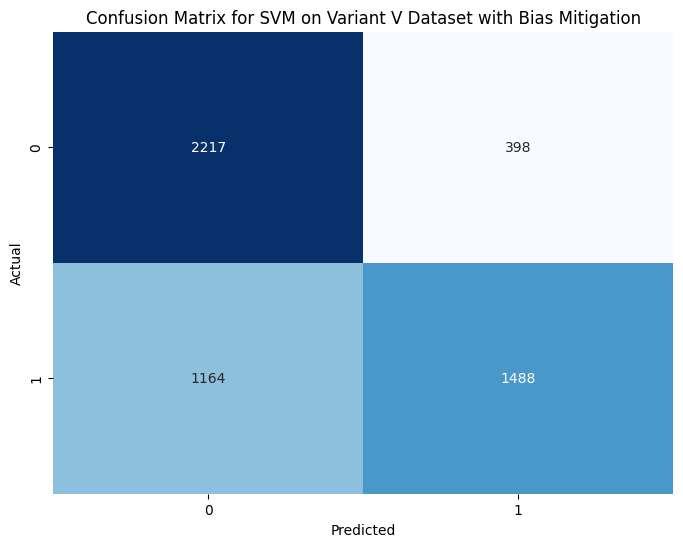

Classification Report for SVM on Variant V Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.66      0.85      0.74      2615
           1       0.79      0.56      0.66      2652

    accuracy                           0.70      5267
   macro avg       0.72      0.70      0.70      5267
weighted avg       0.72      0.70      0.70      5267

ROC-AUC Score for SVM on Variant V Dataset: 0.78

Training and Evaluating Neural Network on Variant V dataset with Bias Mitigation...
epoch 0; iter: 0; batch classifier loss: 0.658520; batch adversarial loss: 0.792899
epoch 1; iter: 0; batch classifier loss: 0.352284; batch adversarial loss: 0.798225
epoch 2; iter: 0; batch classifier loss: 0.351164; batch adversarial loss: 0.753997
epoch 3; iter: 0; batch classifier loss: 0.270688; batch adversarial loss: 0.702023
epoch 4; iter: 0; batch classifier loss: 0.313765; batch adversarial loss: 0.665695
epoch 5; iter: 0; batch classifier loss: 0.284

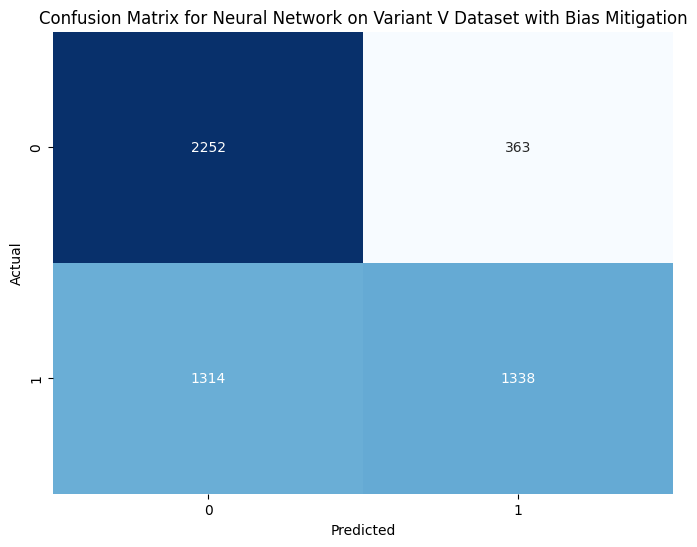

Classification Report for Neural Network on Variant V Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.63      0.86      0.73      2615
           1       0.79      0.50      0.61      2652

    accuracy                           0.68      5267
   macro avg       0.71      0.68      0.67      5267
weighted avg       0.71      0.68      0.67      5267

ROC-AUC Score for Neural Network on Variant V Dataset: Not Applicable

Training and Evaluating LightGBM on Variant V dataset with Bias Mitigation...
[LightGBM] [Info] Number of positive: 8415, number of negative: 8415
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3697
[LightGBM] [Info] Number of data points in the train set: 16830, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.485235 -> initscore=-0.059078
[L

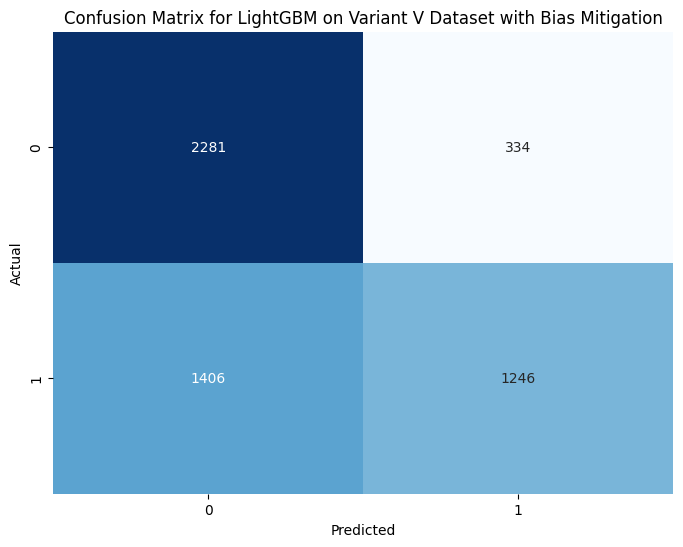

Classification Report for LightGBM on Variant V Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.62      0.87      0.72      2615
           1       0.79      0.47      0.59      2652

    accuracy                           0.67      5267
   macro avg       0.70      0.67      0.66      5267
weighted avg       0.70      0.67      0.66      5267

ROC-AUC Score for LightGBM on Variant V Dataset: 0.75

Training and Evaluating XGBoost on Variant V dataset with Bias Mitigation...


/opt/conda/lib/python3.10/site-packages/fairlearn/postprocessing/_interpolated_thresholder.py:154: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.17455027e-04 2.17455027e-04 2.17455027e-04 ... 2.17455027e-04
 9.93202777e-01 2.17455027e-04]' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  positive_probs[sensitive_feature_vector == a] = interpolated_predictions[


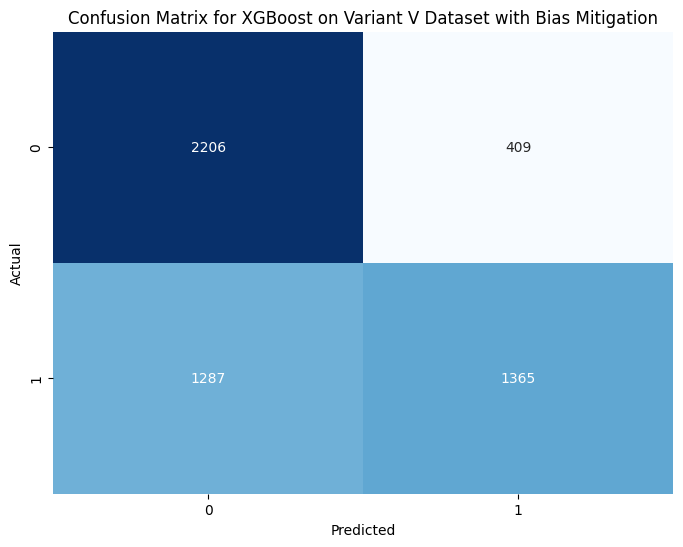

Classification Report for XGBoost on Variant V Dataset with Bias Mitigation:
              precision    recall  f1-score   support

           0       0.63      0.84      0.72      2615
           1       0.77      0.51      0.62      2652

    accuracy                           0.68      5267
   macro avg       0.70      0.68      0.67      5267
weighted avg       0.70      0.68      0.67      5267

ROC-AUC Score for XGBoost on Variant V Dataset: 0.73

Model Training and Evaluation Completed.


In [5]:
# Model Training and Evaluation with Bias Mitigation

# Import necessary libraries
from sklearn.base import clone
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
from fairlearn.postprocessing import ThresholdOptimizer
from aif360.algorithms.inprocessing import AdversarialDebiasing

import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

# Define your models
models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gaussian Naive Bayes": GaussianNB(),
    "Bernoulli Naive Bayes": BernoulliNB(),
    "SVM": SVC(probability=True, random_state=42),
    "Neural Network": MLPClassifier(random_state=42, max_iter=300),
    "LightGBM": LGBMClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
}

trained_models = {}
all_metrics_results = []
bias_metrics_results = []

# Define the sensitive attribute (make sure it matches the one used in preprocessing)
sensitive_attribute = 'employment_status'  # Replace with your sensitive attribute

# Iterate through each dataset and model to train and evaluate them with bias mitigation
for dataset_name, data in train_test_data.items():
    print(f"\nProcessing Dataset: {dataset_name}")

    # Prepare test data for AIF360
    X_test_df = data['X_test'].copy()
    X_test_df[sensitive_attribute] = pd.Series(data['S_test']).reset_index(drop=True)
    X_test_df['label'] = pd.Series(data['y_test']).reset_index(drop=True)

    aif_test_dataset = BinaryLabelDataset(
        favorable_label=1,
        unfavorable_label=0,
        df=X_test_df,
        label_names=['label'],
        protected_attribute_names=[sensitive_attribute]
    )

    for model_name, model in models.items():
        print(f"\nTraining and Evaluating {model_name} on {dataset_name} dataset with Bias Mitigation...")

        # Clone the model
        base_estimator = clone(model)

        # Check if the model supports sample_weight
        if 'sample_weight' in base_estimator.fit.__code__.co_varnames:
            # Models supporting sample_weight - use reweighing
            base_estimator.fit(data['X_train'], data['y_train'], sample_weight=data['sample_weights'])
            y_test_pred = base_estimator.predict(data['X_test'])
            if hasattr(base_estimator, "predict_proba"):
                y_test_prob = base_estimator.predict_proba(data['X_test'])[:, 1]
            else:
                y_test_prob = None
        else:
            # Models not supporting sample_weight
            # Use in-processing or post-processing techniques

            # In-processing with Adversarial Debiasing (if applicable)
            if model_name == "Neural Network":
                # Prepare training data for AIF360
                X_train_df = data['X_train'].copy()
                X_train_df[sensitive_attribute] = pd.Series(data['S_train']).reset_index(drop=True)
                X_train_df['label'] = pd.Series(data['y_train']).reset_index(drop=True)

                aif_train_dataset = BinaryLabelDataset(
                    favorable_label=1,
                    unfavorable_label=0,
                    df=X_train_df,
                    label_names=['label'],
                    protected_attribute_names=[sensitive_attribute]
                )

                # **Reset the default graph to avoid variable conflicts**
                tf.reset_default_graph()

                # Create TensorFlow session
                sess = tf.Session()

                # Initialize Adversarial Debiasing model
                adv_debiasing = AdversarialDebiasing(
                    privileged_groups=[{sensitive_attribute: 1}],
                    unprivileged_groups=[{sensitive_attribute: 0}],
                    scope_name='adv_debiasing',
                    sess=sess,
                    num_epochs=50
                )

                # Train the model
                adv_debiasing.fit(aif_train_dataset)

                # Make predictions
                aif_test_pred = adv_debiasing.predict(aif_test_dataset)
                y_test_pred = aif_test_pred.labels.ravel()
                y_test_prob = None  # Probabilities not available
                sess.close()
            else:
                # Post-processing with ThresholdOptimizer
                base_estimator.fit(data['X_train'], data['y_train'])
                # Apply Threshold Optimizer
                postprocess_est = ThresholdOptimizer(
                    estimator=base_estimator,
                    constraints="equalized_odds",  # or "demographic_parity"
                    prefit=True
                )
                postprocess_est.fit(
                    data['X_train'],
                    data['y_train'],
                    sensitive_features=data['S_train']
                )
                y_test_pred = postprocess_est.predict(
                    data['X_test'],
                    sensitive_features=data['S_test']
                )
                if hasattr(base_estimator, "predict_proba"):
                    y_test_prob = base_estimator.predict_proba(data['X_test'])[:, 1]
                else:
                    y_test_prob = None

        # Calculate metrics
        cm = confusion_matrix(data['y_test'], y_test_pred)
        report = classification_report(data['y_test'], y_test_pred, output_dict=True)

        # Calculate ROC-AUC score
        if y_test_prob is not None:
            roc_auc = roc_auc_score(data['y_test'], y_test_prob)
        else:
            roc_auc = None  # Use None when ROC-AUC is not available

        # Print Confusion Matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"Confusion Matrix for {model_name} on {dataset_name} Dataset with Bias Mitigation")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

        # Print Classification Report and ROC-AUC
        print(f"Classification Report for {model_name} on {dataset_name} Dataset with Bias Mitigation:")
        print(classification_report(data['y_test'], y_test_pred))

        if roc_auc is not None:
            print(f"ROC-AUC Score for {model_name} on {dataset_name} Dataset: {roc_auc:.2f}")
        else:
            print(f"ROC-AUC Score for {model_name} on {dataset_name} Dataset: Not Applicable")

        # Evaluate fairness metrics
        dp_diff = demographic_parity_difference(
            y_true=data['y_test'],
            y_pred=y_test_pred,
            sensitive_features=data['S_test']
        )

        eo_diff = equalized_odds_difference(
            y_true=data['y_test'],
            y_pred=y_test_pred,
            sensitive_features=data['S_test']
        )

        # Store all metrics results
        all_metrics_results.append({
            'Dataset': dataset_name,
            'Model': model_name,
            'Accuracy': accuracy_score(data['y_test'], y_test_pred),
            'F1 Score': f1_score(data['y_test'], y_test_pred),
            'ROC-AUC Score': roc_auc if roc_auc is not None else 'N/A',
            'Demographic Parity Difference': dp_diff,
            'Equalized Odds Difference': eo_diff
        })

        # Store bias metrics separately for plotting
        bias_metrics_results.append({
            'Dataset': dataset_name,
            'Model': model_name,
            'Demographic Parity Difference': dp_diff,
            'Equalized Odds Difference': eo_diff
        })

print("\nModel Training and Evaluation Completed.")

In [6]:
# Convert all metrics results to DataFrame for visualization
all_metrics_df = pd.DataFrame(all_metrics_results)
bias_summary = pd.DataFrame(bias_metrics_results)

# Print All Metrics Summary
print("\nAll Metrics Summary:")
print(all_metrics_df)


All Metrics Summary:
        Dataset                  Model  Accuracy  F1 Score ROC-AUC Score  \
0          Base    Logistic Regression  0.773029  0.784749       0.85918   
1          Base                    KNN  0.694770  0.704906      0.805919   
2          Base          Random Forest  0.790203  0.808549      0.870793   
3          Base   Gaussian Naive Bayes  0.762490  0.780444      0.817851   
4          Base  Bernoulli Naive Bayes  0.763466  0.790890      0.834977   
5          Base                    SVM  0.795863  0.816556      0.870002   
6          Base         Neural Network  0.789617  0.804569           N/A   
7          Base               LightGBM  0.804059  0.820778       0.88266   
8          Base                XGBoost  0.782006  0.800571      0.870641   
9     Variant I    Logistic Regression  0.760343  0.769951      0.845725   
10    Variant I                    KNN  0.640906  0.607509      0.796306   
11    Variant I          Random Forest  0.793130  0.814361      0.

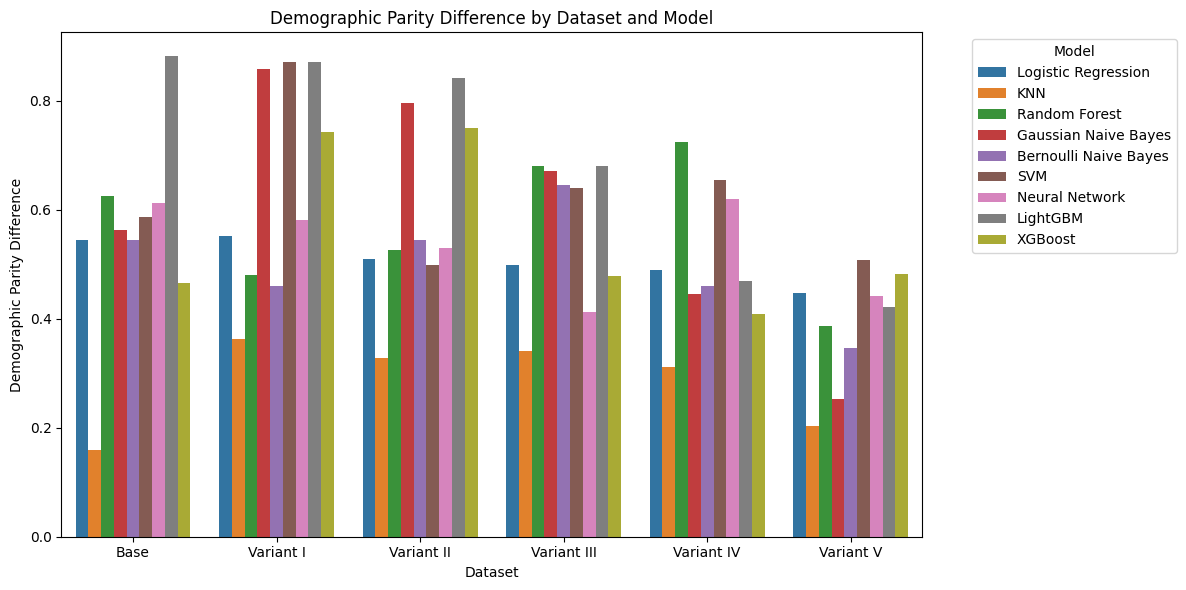

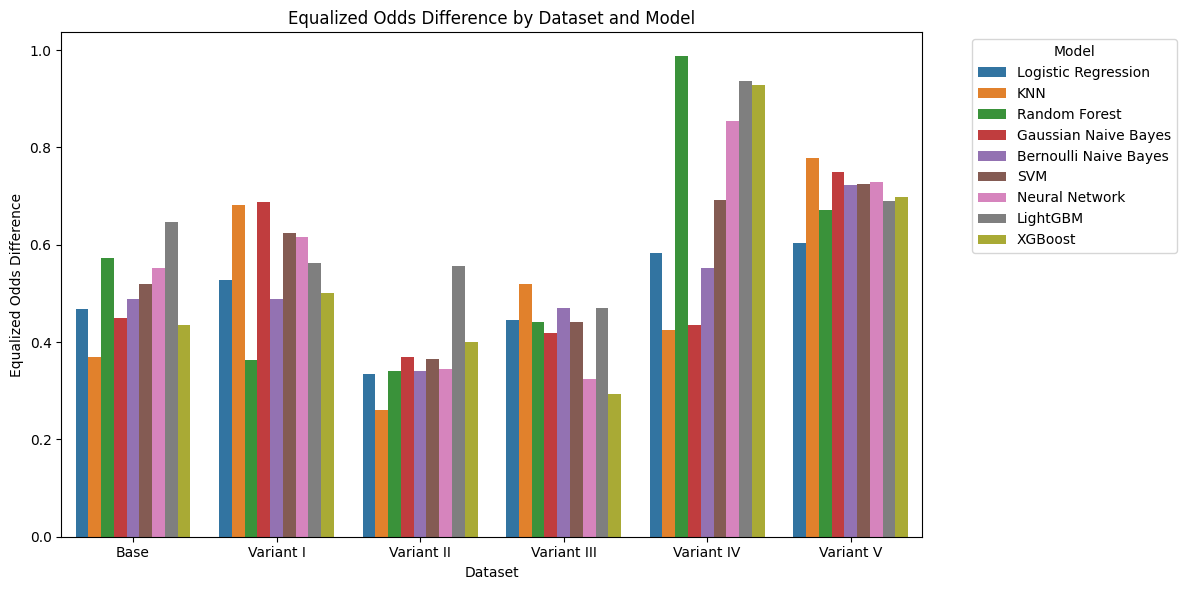

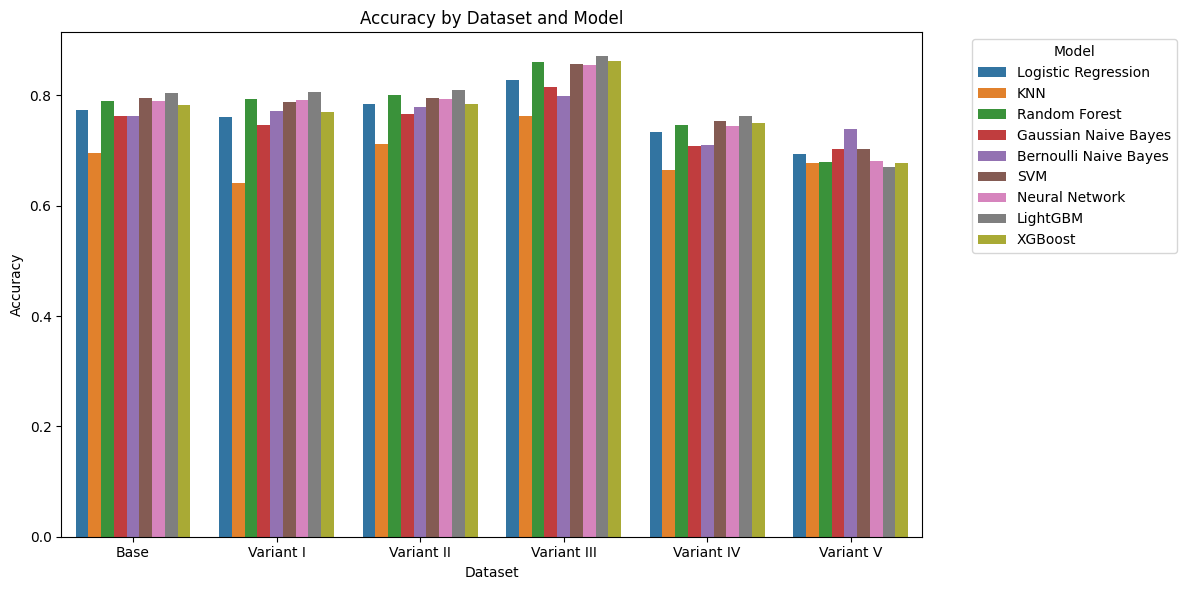

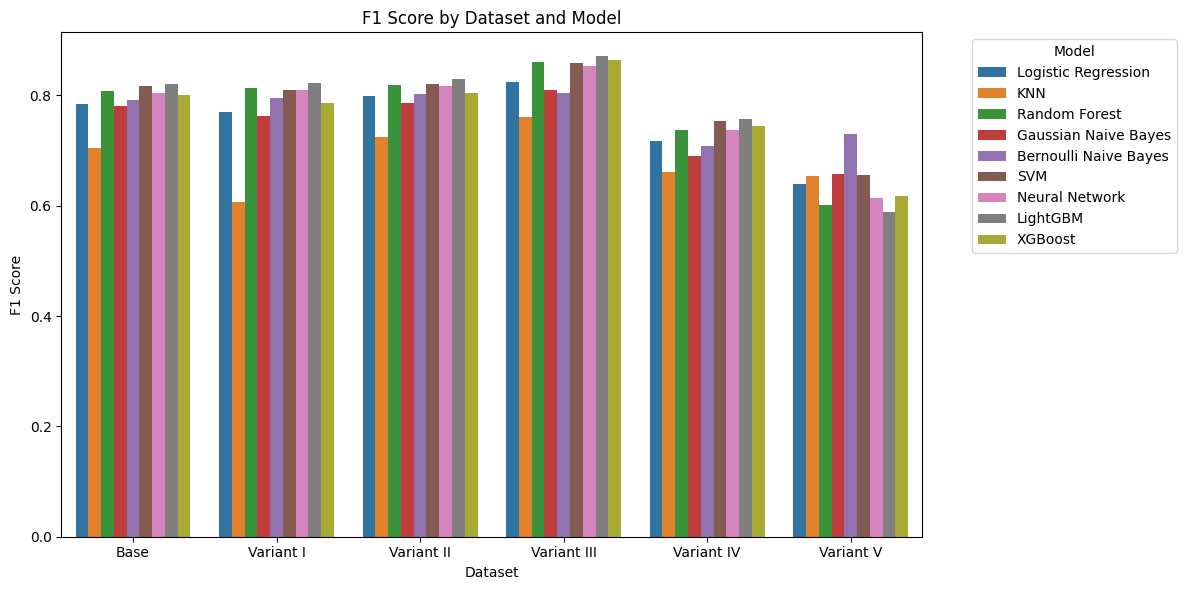

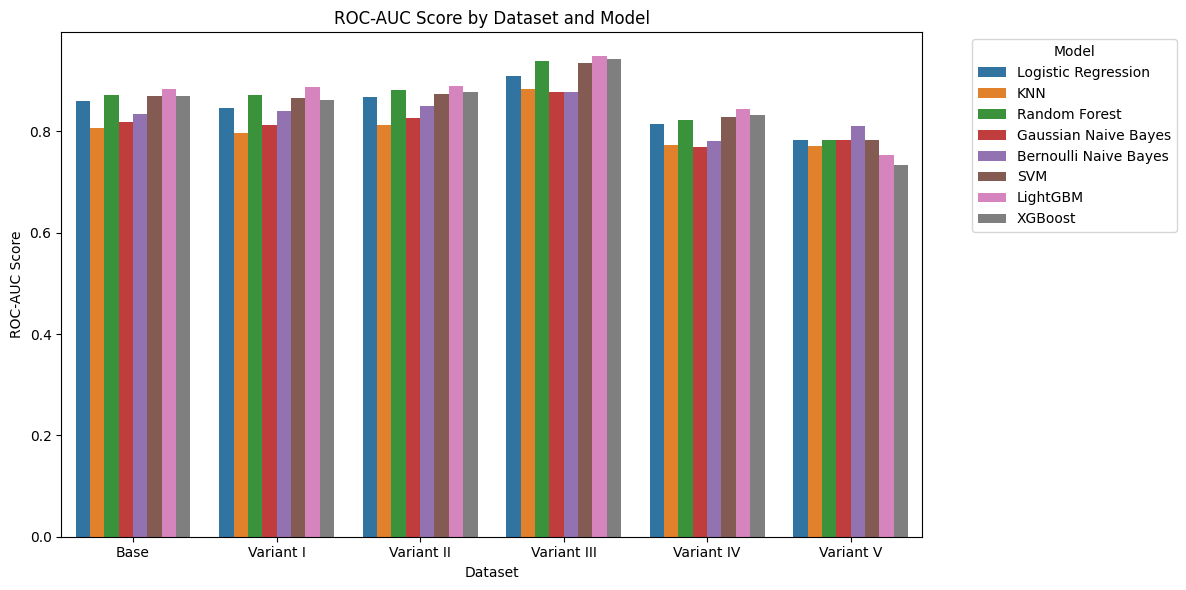

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting Demographic Parity Difference by Dataset and Model
plt.figure(figsize=(12, 6))
sns.barplot(data=all_metrics_df, x='Dataset', y='Demographic Parity Difference', hue='Model')
plt.title('Demographic Parity Difference by Dataset and Model')
plt.xlabel('Dataset')
plt.ylabel('Demographic Parity Difference')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plotting Equalized Odds Difference by Dataset and Model
plt.figure(figsize=(12, 6))
sns.barplot(data=all_metrics_df, x='Dataset', y='Equalized Odds Difference', hue='Model')
plt.title('Equalized Odds Difference by Dataset and Model')
plt.xlabel('Dataset')
plt.ylabel('Equalized Odds Difference')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plotting Accuracy by Dataset and Model
plt.figure(figsize=(12, 6))
sns.barplot(data=all_metrics_df, x='Dataset', y='Accuracy', hue='Model')
plt.title('Accuracy by Dataset and Model')
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plotting F1 Score by Dataset and Model
plt.figure(figsize=(12, 6))
sns.barplot(data=all_metrics_df, x='Dataset', y='F1 Score', hue='Model')
plt.title('F1 Score by Dataset and Model')
plt.xlabel('Dataset')
plt.ylabel('F1 Score')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plotting ROC-AUC Score by Dataset and Model (if applicable)
roc_auc_df = all_metrics_df[all_metrics_df['ROC-AUC Score'] != 'N/A']
if not roc_auc_df.empty:
    plt.figure(figsize=(12, 6))
    sns.barplot(data=roc_auc_df, x='Dataset', y='ROC-AUC Score', hue='Model')
    plt.title('ROC-AUC Score by Dataset and Model')
    plt.xlabel('Dataset')
    plt.ylabel('ROC-AUC Score')
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


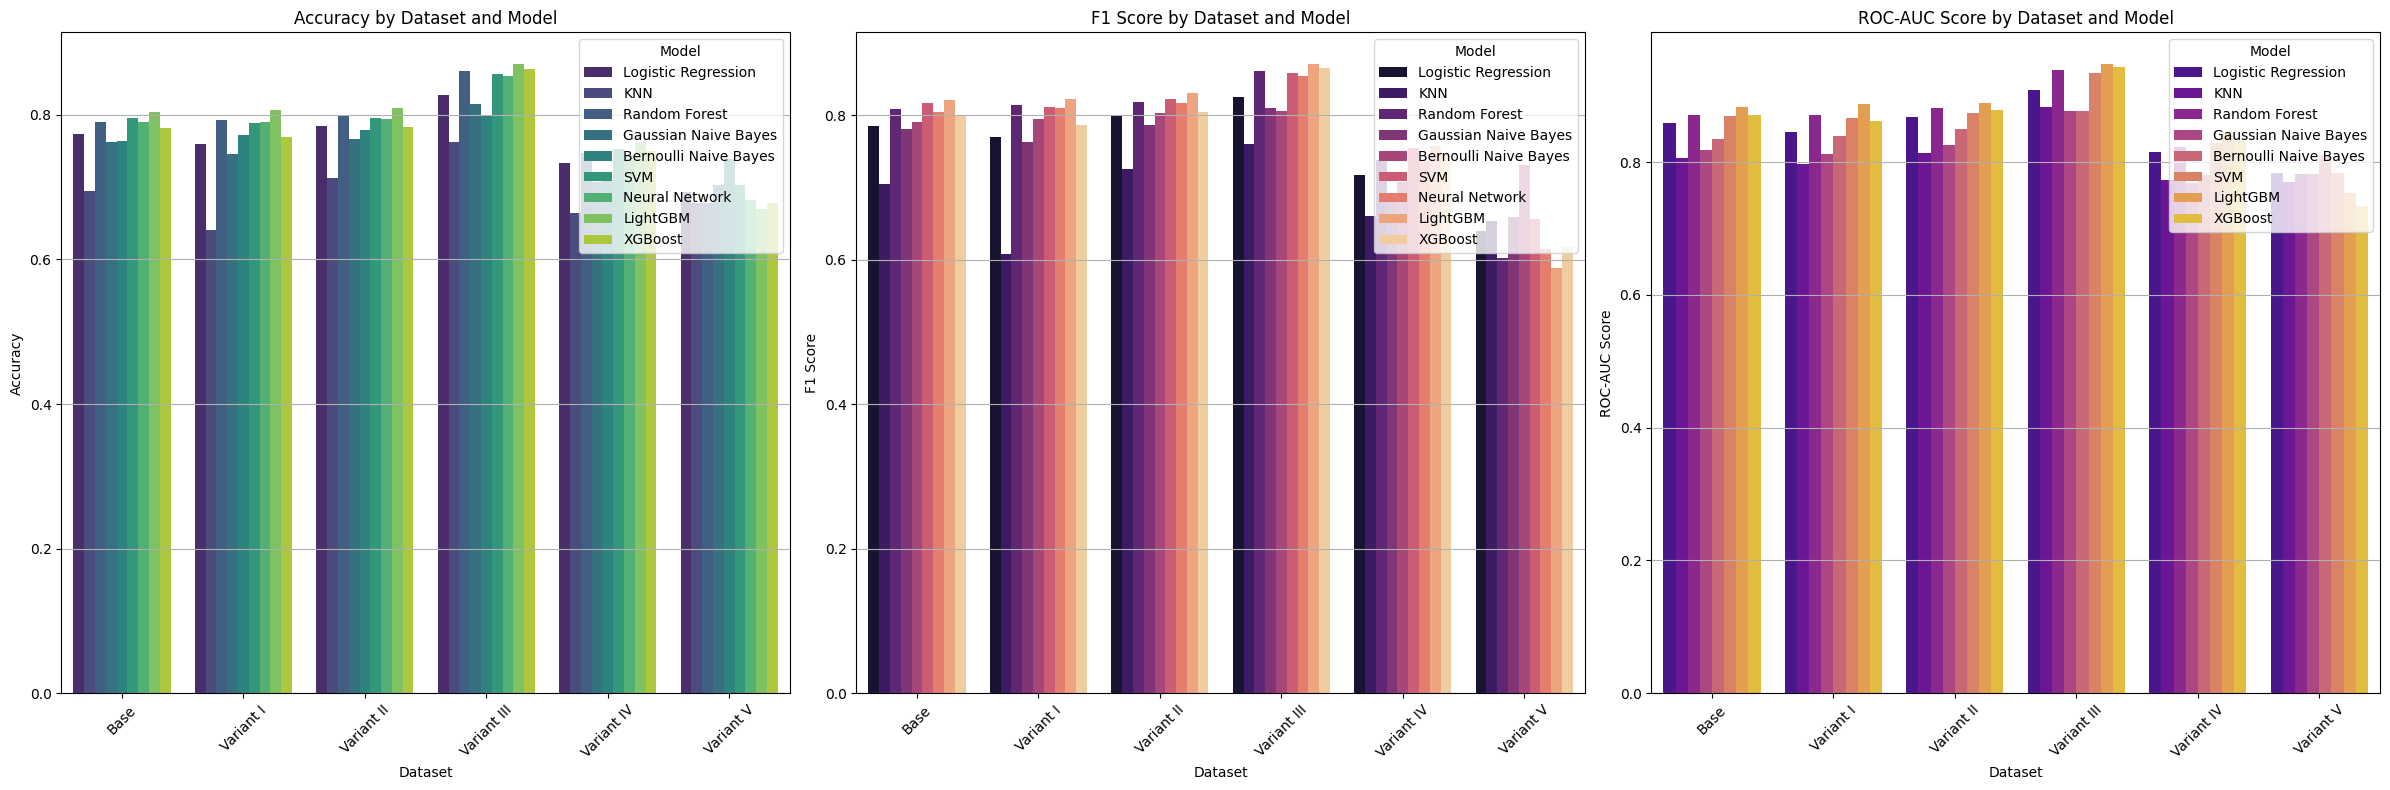

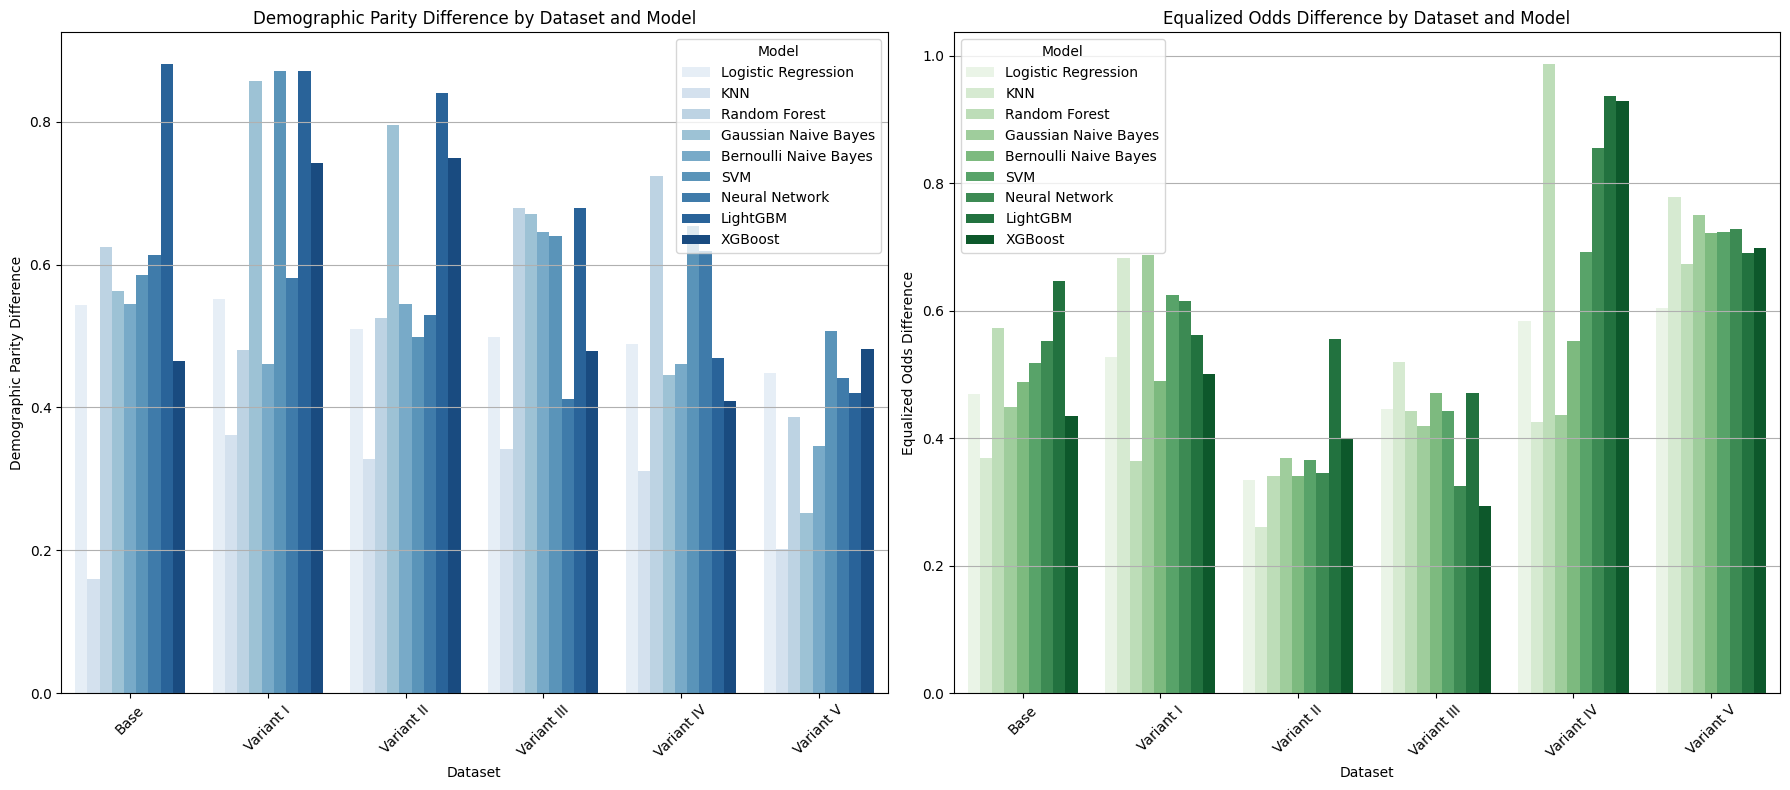

In [8]:
# Plotting All Metrics Summary
fig, axs = plt.subplots(1, 3, figsize=(24, 8))

# Plot Accuracy for all datasets and models
sns.barplot(data=all_metrics_df, x='Dataset', y='Accuracy', hue='Model', ax=axs[0], palette='viridis')
axs[0].set_title('Accuracy by Dataset and Model')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Dataset')
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(axis='y')

# Plot F1 Score for all datasets and models
sns.barplot(data=all_metrics_df, x='Dataset', y='F1 Score', hue='Model', ax=axs[1], palette='magma')
axs[1].set_title('F1 Score by Dataset and Model')
axs[1].set_ylabel('F1 Score')
axs[1].set_xlabel('Dataset')
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(axis='y')

# Plot ROC-AUC Score for all datasets and models (if applicable)
sns.barplot(data=all_metrics_df[all_metrics_df['ROC-AUC Score'] != 'N/A'], x='Dataset', y='ROC-AUC Score', hue='Model', ax=axs[2], palette='plasma')
axs[2].set_title('ROC-AUC Score by Dataset and Model')
axs[2].set_ylabel('ROC-AUC Score')
axs[2].set_xlabel('Dataset')
axs[2].tick_params(axis='x', rotation=45)
axs[2].grid(axis='y')

plt.tight_layout()
plt.show()

# Plotting Bias Metrics
fig, axs = plt.subplots(1, 2, figsize=(18, 8))

# Plot Demographic Parity Difference for all datasets and models
sns.barplot(data=bias_summary, x='Dataset', y='Demographic Parity Difference', hue='Model', ax=axs[0], palette='Blues')
axs[0].set_title('Demographic Parity Difference by Dataset and Model')
axs[0].set_ylabel('Demographic Parity Difference')
axs[0].set_xlabel('Dataset')
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(axis='y')

# Plot Equalized Odds Difference for all datasets and models
sns.barplot(data=bias_summary, x='Dataset', y='Equalized Odds Difference', hue='Model', ax=axs[1], palette='Greens')
axs[1].set_title('Equalized Odds Difference by Dataset and Model')
axs[1].set_ylabel('Equalized Odds Difference')
axs[1].set_xlabel('Dataset')
axs[1].tick_params(axis='x', rotation=45)
axs[1].grid(axis='y')

plt.tight_layout()
plt.show()
